# Twitter Sentiment Project

This project aimed to use NLP techniques to build a model to analyze Tweets from the given dataset. During the EDA process I was to go through the dataset - Tweets from South by Southwest about Apple and Google and I processed them for modeling. The modeling results and preprocessing results are in this notebook. It will reference the other three notebooks of the project.

## Business Problem

The objective of this project was to build a binary classifier that could tackle the challenge of identifying negative tweets in a sea of positive and neutral tweets. This was a highly imbalanced dataset, so the challenge was to build a classifier that was up to the task. 

In [9]:
#Basic Imports
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 0)

In [74]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
import pickle

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [119]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [32]:
import sys

sys.path.insert(0, '/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Helper_Functions')
import functions as fn

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [125]:
#Natural Language Toolkit Imports
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## The Dataset

### Original Raw DataSet

In [7]:
#Problems with errors, using ignore parameter
with open('/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Data/judge-1377884607_tweet_product_company.csv', encoding='UTF8', errors='ignore') as f:
    data = pd.read_csv(f)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


### Rename Columns

In [13]:
#Renaming Columns to shorter names
names = {'emotion_in_tweet_is_directed_at': 'Product',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'}
data.rename(columns=names,
          inplace=True)

In [14]:
data['Sentiment'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: Sentiment, dtype: float64

In [15]:
data['Sentiment']=data['Sentiment'].str.replace('No emotion toward brand or product','Neutral')
data['Sentiment']=data['Sentiment'].str.replace('Positive emotion','Positive')
data['Sentiment']=data['Sentiment'].str.replace('Negative emotion','Negative')

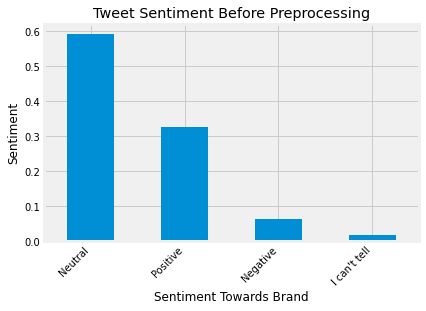

In [16]:
plt.style.use('fivethirtyeight')
data['Sentiment'].value_counts(normalize=True).plot.bar()
plt.title('Tweet Sentiment Before Preprocessing')
plt.ylabel('Sentiment')
plt.xlabel('Sentiment Towards Brand')
plt.xticks(rotation=45, ha='right')
plt.show()

### Product Columns

In [19]:
data['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                        81 
Android                            78 
Other Apple product or service     35 
Name: Product, dtype: int64

In [21]:
np.sum(data['Product'].isna())

5802

In [22]:
np.sum(data['Product'].isna()/len(data))

0.6380732431540745

During EDA and PreProcessing I was able to expand the product column and eliminate nulls through imputing values. I will import that product processed dataset. Lens represent a great 63% of the dataset at this time. 

### Product Processed Dataset

In [24]:
data = pd.read_csv('/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Data/product_processed.csv')

In [25]:
data.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  
0  iPhone              Negative  
1  iPad or iPhone App  Positive  
2  iPad                Positive  
3  iPad or iPhone App  Negative  
4  Google              Positive

In [27]:
np.sum(data['Product'].isna())/len(data)

0.0

In [28]:
data['Product'].value_counts()

iPad                               2054
Google                             1759
Apple                              1210
iPhone                             888 
iPad or iPhone App                 470 
Android                            312 
Other Google product or service    292 
google                             259 
apple                              116 
ipad                               116 
Name: Product, dtype: int64

In [30]:
len(data)

7476

The EDA preprocessing eliminated nulls, replaced them with an 'unknown' value, those values were then dropped. In total 1617 values were dropped from the dataset because they were irrelevant or duplicates.

## Text Processing

Text processing was preformed with a local function. During each step of the processing I investigated the changes made. Those change can be found in the EDA notebook.

In [34]:
data['processed_text']=fn.Process_Tweet(data['tweet_text'],remove_HTML=True,remove_numerals=True,replace_moji_bake=True,remove_hashtags=True,contraction_fix=True,no_leading=True,lower=True,remove_mentions=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [35]:
data['processed_text'].head()

0     i have a  three g iphone. after  three  hrs tweeting at , it was dead!  i need to upgrade. plugin stations at .        
1     know about  ? awesome ipad/iphone app that you will likely appreciate for its design. also, they are giving free ts at 
2     can not wait for   two  also. they should sale them down at .                                                          
3     i hope this year's festival is not as crashy as this year's iphone app.                                                
4     great stuff on fri : marissa mayer (google), tim o'reilly (tech books/conferences) & matt mullenweg (wordpress)        
Name: processed_text, dtype: object

In [44]:
#Grabbing Stopwords from NLTK
sw = stopwords.words('english')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Model Target

This project became a binary classifier, the neutral and positive tweets were combined into one value and the negative tweets were set as '1' as the main target.

In [37]:
#Setting Target as numeric
data['Sentiment']=data['Sentiment'].replace({"Positive": 0, "Negative": 1, "Neutral": 3}).astype(np.uint8)
#combining neutral and positive sentiments
data['Sentiment']=data['Sentiment'].replace(3,0).copy()

In [39]:
data['Sentiment'].value_counts(normalize=True)

0    0.925094
1    0.074906
Name: Sentiment, dtype: float64

In [47]:
X = data['processed_text']
token_docs = [fn.doc_preparer(doc, sw) for doc in X]
y = data['Sentiment']

['three', 'g', 'iphone', 'three', 'hrs', 'tweeting', 'dead', 'need', 'upgrade', 'plugin', 'stations']
['know', 'awesome', 'ipad', 'iphone', 'app', 'likely', 'appreciate', 'design', 'also', 'giving', 'free', 'ts']
['wait', 'two', 'also', 'sale']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app']
['great', 'stuff', 'fri', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'communication', 'showcased', 'conference', 'http', 'ht', 'ly', 'forty', 'nine', 'n', 'four']
['starting', 'around', 'corner', 'hop', 'skip', 'jump', 'good', 'time', 'fan']
['beautifully', 'smart', 'simple', 'idea', 'rt', 'wrote', 'ipad', 'app', 'http', 'bit', 'ly', 'ieavob']
['counting', 'days', 'plus', 'strong', 'canadian', 'dollar', 'means', 'stock', 'apple', 'gear']
['excited', 'meet', 'show', 'sprint', 'galaxy', 'still', 'running', 'android', 'two', 'one']
['find', 'start', 'impromptu', 'parties', 'http', 'bit', 'ly',

['ipad', 'store', 'sold', 'everything', 'except', 'sixty', 'four', 'gig', 'wifi', 'white', 'also', 'known', 'white', 'jeans', 'configuration']
['offered', 'ipad', 'promo', 'ninjafinder', 'users', 'fans', 'sucks']
['austin', 'conference', 'google', 'search', 'interactive', 'music', 'film']
['marc', 'ecko', 'launches', 'app', 'autodial', 'political', 'change', 'link']
['learning', 'life', 'changing', 'impact', 'ipad', 'real', 'people', 'actual', 'lives', 'bravo']
['lonelyplanet', 'austin', 'guide', 'free', 'limited', 'time', 'link']
['anyone', 'heading', 'aclu', 'event', 'seen', 'owt', 'google', 'circles']
['prompt', 'memory', 'go', 'google', 'map', 'describe', 'childhood', 'walk']
['apple', 'store', 'still', 'ipad', 'two', 'short', 'lines']
['left', 'tradeshow', 'demo', 'google', 'theatre', 'ok', 'get', 'see', 'presenters', 'using']
['following', 'tweets', 'google', 'realtime', 'four', 'platforms', 'tweet', 'deck', 'listening', 'panel', 'realizing', 'spoken', 'one', 'today']
['anyone', 

['great', 'certain', 'meetings', 'rt', 'hello', 'holler', 'gram', 'new', 'ipad', 'app', 'link']
['miss', 'charles', 'chen', 'android', 'chromeos', 'access', 'sxsw', 'google', 'booth', 'exhibit', 'hall', 'three', 'one', 'pm']
['group', 'chat', 'apps', 'told', 'l', 'two', 'apps', 'yet', 'avail', 'android', 'point', 'need', 'phone', 'apps']
['daily', 'chord', 'tuesday', 'march', 'eight', 'hackers', 'discover', 'google', 'music', 'servicestory', 'rollin', 'link']
['daily', 'chord', 'tuesday', 'march', 'eight', 'hackers', 'discover', 'google', 'music', 'servicestory', 'rolling', 'stone', 'mo', 'link']
['google', 'circle', 'austin', 'link']
['google', 'circles', 'link', 'ht', 'maybe', 'reconsidering', 'shape']
['google', 'circles', 'rt', 'launching', 'products', 'plenty', 'else']
['ten', 'austin', 'classics', 'missed', 'four', 'blog', 'com', 'twitter', 'iphone', 'three', 'twelve', 'eleven', 'twelve', 'forty', 'pm']
['trying', 'collaborate', 'events', 'friends', 'google', 'calendar', 'plancas

['wonder', 'fit', 'ipad', 'two', 'luggage', 'packing', 'austin', 'hmmm']
['holy', 'moly', 'cannot', 'believe', 'line', 'apple', 'store', 'sxsw', 'link']
['could', 'forget', 'cell', 'phone', 'today', 'fail', 'glad', 'ipad']
['three', 'g', 'iphone', 'three', 'hrs', 'tweeting', 'dead', 'need', 'upgrade', 'plugin', 'stations']
['feeling', 'worst', 'place', 'try', 'get', 'ipad', 'two', 'everyone', 'trying', 'get', 'one']
['love', 'macbook', 'ipad', 'iphone', 'year', 'one', 'runs', 'juice', 'jump', 'next']
['holy', 'cow', 'got', 'hooked', 'paolo', 'alex', 'backup', 'charger', 'iphone', 'facebook', 'com', 'powermat']
['holy', 'cow', 'got', 'hooked', 'paolo', 'alex', 'backup', 'charger', 'iphone', 'facebook', 'com', 'powermat']
['knew', 'plied', 'beer', 'stogies', 'last', 'night', 'would', 'weasel', 'way', 'team', 'android', 'party', 'tonight']
['ok', 'nerds', 'totally', 'bateman', 'want', 'sign', 'ipad', 'two']
['last', 'year', 'traveled', 'heavy', 'year', 'light', 'get', 'right', 'next', 'ye

['great', 'vid', 'marty', 'rt', 'live', 'unboxing', 'front', 'apple', 'store', 'video', 'link']
['think', 'may', 'go', 'ipad', 'laptop', 'today', 'veterans', 'reasons']
['made', 'ambassador', 'upload', 'music', 'shows', 'reward', 'rt', 'soundcloud', 'android', 'app', 'fresh']
['come', 'find', 'booth', 'two', 'cases', 'left', 'one', 'win']
['omfg', 'means', 'please', 'link', 'webber', 'ipad', 'dionne', 'warwick']
['alert', 'media', 'saw', 'one', 'android', 'tablet', 'like', 'finding', 'needle', 'haystack', 'also', 'saw', 'cr', 'forty', 'eight']
['great', 'mental', 'image', 'rt', 'people', 'session', 'taking', 'photos', 'w', 'ipad', 'two', 'air']
['think', 'might', 'go', 'weekend', 'without', 'seeing', 'ipad', 'case', 'twice']
['sure', 'mine', 'via', 'ipad', 'rt', 'know', 'relies', 'evernote', 'link']
['bummed', 'miss', 'year', 'quarantined', 'kiddie', 'cold', 'garageband', 'ipad', 'comfort']
['miss', 'knew', 'spotted', 'nfc', 'enabled', 'google', 'places', 'marker', 'birds', 'wonder', '

['seen', 'several', 'people', 'working', 'ipad', 'two', 'today']
['short', 'line', 'building', 'flash', 'apple', 'store', 'downtown', 'people', 'want', 'new', 'ipads']
['exclusive', 'shot', 'popup', 'apple', 'store', 'link']
['guess', 'say', 'told', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'ipad', 'two', 'launch', 'link']
['art', 'show', 'time', 'check', 'interactive', 'fools']
['mayer', 'showcasing', 'google', 'places', 'hotpot', 'restaurants', 'rating', 'tool', 'hello', 'mobile', 'advertising', 'check', 'ins', 'push']
['danger', 'sitting', 'floor', 'charging', 'laptop', 'ipod', 'iphone', 'etc', 'dreaded', 'dead', 'butt', 'damn', 'tingles']
['spilled', 'beans', 'next', 'platform', 'flipboard', 'iphone', 'team', 'started', 'working']
['spilled', 'beans', 'next', 'platform', 'flipboard', 'iphone', 'team', 'started', 'working', 'gr', 'eight']
['new', 'ipad']
['impressed', 'far', 'ipad', 'two', 'slim', 'form', 'instant', 'ness', 'seen', 'tried', 'one', 'yet']
['smar

['way', 'anyone', 'seen', 'lines', 'sxsw', 'apple', 'store', 'still', 'bit', 'early']
['traveling', 'ipad', 'one', 'three', 'ten', 'two', 'thousand', 'eleven']
['way', 'forgot', 'ipad', 'cleveland', 'hopkins', 'airport', 'w', 'two', 'others', 'link']
['listening', 'furby', 'choir']
['talked', 'googler', 'said', 'new', 'products', 'point', 'google', 'social', 'search', 'link']
['metric', 'determine', 'engagement', 'session', 'ipad', 'battery', 'drained', 'using', 'nine', 'session', 'one']
['listening', 'folks', 'around', 'world', 'making', 'iphone', 'music', 'smule', 'ocarina', 'played', 'zelda', 'theme']
['according', 'google', 'marissa', 'mayer', 'future', 'location', 'augmented', 'reality', 'contextual', 'discovery', 'making', 'smartphones', 'smarter']
['listening', 'google', 'q', 'saying', 'see', 'yelp', 'services', 'going', 'die', 'far', 'interesting']
['listening', 'google', 'marissa', 'mayer', 'discuss', 'new', 'products', 'including', 'google', 'hotpot', 'watch', 'yelp']
['liste

['look', 'guys', 'simple', 'personal', 'clouds', 'cannot', 'exist', 'without', 'unless', 'want', 'pay', 'fifty', 'static', 'ip']
['classiest', 'fascist', 'company', 'america', 'really', 'elegant']
['mint', 'com', 'confines', 'coding', 'iphone', 'app', 'luxury', 'worry', 'learning', 'different', 'phone', 'versions']
['hey', 'ers', 'rt', 'rt', 'last', 'day', 'get', 'austin', 'iphone', 'app', 'free', 'link']
['false', 'alarm', 'google', 'circles', 'coming', 'nowand', 'probably', 'ever', 'link']
['google', 'maps', 'five', 'twenty', 'two', 'great', 'job']
['got', 'copy', 'today', 'excited', 'thanks', 'keeping', 'world', 'enchanted', 'glad']
['sxsw', 'people', 'see', 'bargain', 'apple', 'booth', 'tryna', 'bargain', 'call', 'girl', 'backpages']
['lynn', 'teo', 'new', 'nav', 'schemas', 'ipad', 'link']
['overcome', 'provide', 'social', 'proof', 'apple', 'white', 'earbuds', 'via']
['print', 'tablets', 'web', 'tablets', 'needed', 'bridge', 'gap']
['rt', 'new', 'app', 'store', 'includes', 'ubergui

['rt', 'ubersoc', 'new', 'app', 'store', 'includes', 'uberguide', 'cont', 'link']
['ceo', 'gowalla', 'tells', 'journey', 'blinksale', 'iconbuffet', 'packrat', 'born', 'lightbulb', 'turned']
['anyone', 'knows', 'found', 'deaddd', 'iphone', 'outside', 'blogger', 'lounge', 'contact', 'reunite']
['via', 'ipad', 'store', 'sold', 'everything', 'except', 'sixty', 'four', 'gig', 'wifi', 'white']
['cnnmoney', 'two', 'thousand', 'eleven', 'computing', 'device', 'bigger', 'ipad', 'pass', 'mobile', 'space', 'buzz', 'link']
['rt', 'look', 'everyone', 'zomg', 'got', 'ipad', 'two', 'first', 'day', 'link']
['sure', 'link', 'double', 'rainbow', 'kind', 'day', 'right']
['link', 'get', 'app', 'yet', 'android', 'version', 'schedule']
['tried', 'new', 'ipad', 'app', 'beautiful', 'ps', 'thanks', 'tvontheradio', 'tix', 'rock']
['google', 'circles', 'new', 'social', 'media', 'site', 'wow']
['studies', 'players', 'tell', 'us', 'petting', 'iphone', 'makes', 'happy']
['apple', 'opening', 'temporary', 'store', 'd

['rumor', 'google', 'launch', 'new', 'social', 'network', 'called', 'circles', 'link']
['sixty', 'four', 'gb', 'ipad', 'two', 'three', 'g', 'paypal', 'right']
['worthy', 'since', 'know', 'ux', 'rt', 'product', 'iphone', 'period', 'ux']
['fear', 'ers', 'rt', 'confirmed', 'apple', 'store', 'two', 'week', 'popup', 'austin', 'link']
['schools', 'marketing', 'experts', 'link']
['schools', 'marketing', 'experts', 'thousands', 'town', 'demonstrate', 'social', 'link']
['apple', 'schools', 'marketing', 'experts', 'link']
['apple', 'schools', 'marketing', 'experts', 'link']
['bored', 'try', 'iphone', 'app', 'link']
['today', 'bulletproof', 'ux', 'strategy', 'games', 'design', 'patterns', 'google', 'anatomy', 'design', 'decision']
['free', 'fluffertrax', 'radio', 'app', 'link']
['going', 'come', 'consulting', 'booth', 'chance', 'win', 'ipad', 'two']
['going', 'google', 'map', 'free', 'wi', 'fi', 'hotspots', 'link', 'warning', 'two', 'thousand', 'nine']
['going', 'plan', 'visit', 'booth', 'chance'

['biggest', 'takeaway', 'thus', 'far', 'bring', 'physical', 'world', 'ipad', 'design', 'recreate', 'already', 'learned', 'experiences']
['big', 'takeaway', 'interactive', 'need', 'iphone']
['guy', 'kawasaki', 'believe', 'god', 'explanation', 'continuous', 'survival', 'apple', 'years', 'lol']
['guy', 'kawasaki', 'ex', 'apple', 'evangelist', 'talking', 'eloquently', 'art', 'enchantment', 'changing', 'hearts', 'minds', 'actions']
['google', 'taking', 'new', 'product', 'called', 'hotpot', 'review', 'recommendations', 'engine', 'also', 'social', 'tool']
['apple', 'taking', 'old', 'ipads', 'teach', 'america', 'user', 'gets', 'tax', 'write', 'buy', 'new', 'ipad', 'kind', 'cool']
['nine', 'essential', 'apps', 'beyond', 'underwire', 'wired', 'com', 'link']
['five', 'essential', 'business', 'apps', 'link']
['existential', 'google', 'mt', 'contextual', 'discovery', 'demo', 'history', 'time', 'search', 'refine', 'results']
['informal', 'unscientific', 'observation', 'far', 'computer', 'choice', 'h

['google', 'quash', 'circles', 'rumours', 'rt', 'launching', 'products', 'plenty', 'else', 'link']
['flash', 'discussion', 'still', 'relevant', 'ipad', 'design', 'headaches']
['got', 'flask', 'ipad', 'yes', 'sitting', 'nine', 'th', 'st', 'waiting', 'aicn', 'screening', 'iloveasurprise', 'link']
['guy', 'asked', 'google', 'mayer', 'take', 'year', 'remove', 'deadly', 'routes', 'google', 'maps', 'death', 'valley']
['like', 'asserted', 'corporate', 'new', 'indie', 'rt', 'well', 'damn', 'apple', 'setting', 'pop', 'shop', 'link']
['rockin', 'could', 'cooler', 'link']
['also', 'known', 'hershel', 'iphone', 'autocorrect', 'link']
['nyt', 'wsj', 'ask', 'future', 'branded', 'native', 'news', 'apps', 'ipad', 'link']
['nine', 'ten', 'attendees', 'mac', 'ipad']
['apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'via']
['apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'via']
['apple', 'comes', 'cool', 'technology', 'one', 'ever',

['apple', 'grabbed', 'tablet', 'mindshare', 'rim', 'owns', 'one', 'popular', 'events', 'link']
['apple', 'grabbed', 'tablet', 'mindshare', 'rim', 'owns', 'one', 'popular', 'events', 'link']
['got', 'bbq', 'iphone']
['funny', 'psfk', 'session', 'sponsored', 'microsoft', 'talk', 'apple']
['going', 'awesome', 'rt', 'gallery', 'original', 'daniel', 'johnston', 'art', 'going', 'tomorrow', 'industry', 'party']
['going', 'big', 'google', 'gets', 'using', 'q', 'site', 'hipster', 'sxsw', 'link']
['interviewed', 'mashable', 'waiting', 'line', 'popup', 'apple', 'store']
['see', 'member', 'team', 'carrying', 'one', 'bags', 'show', 'wolfram', 'app', 'get', 'w', 'iphone', 'case', 'link']
['see', 'member', 'team', 'bag', 'show', 'wolfram', 'app', 'get', 'w', 'case', 'iphone', 'link']
['enjoying', 'berkowitz', 'talk', 'rfid', 'ncf', 'impact', 'mobile', 'retail', 'would', 'carry', 'nfc', 'phone', 'google', 'bullish', 'ballroom', 'e']
['best', 'thing', 'heard', 'gave', 'ipad', 'two', 'money', 'relief', 

['opening', 'pop', 'store', 'austin', 'geekfest', 'apple', 'link']
['saves', 'set', 'open', 'pop', 'store', 'link']
['wants', 'new', 'camera', 'app', 'link']
['schools', 'marketing', 'experts', 'link']
['even', 'begins', 'wins', 'link']
['google', 'launch', 'new', 'social', 'network', 'link']
['link', 'security', 'guard', 'enjoying', 'ipad', 'two', 'apple', 'store', 'austin']
['media', 'circus', 'guy', 'walks', 'apple', 'popup', 'store', 'one', 'st', 'austin', 'six', 'th', 'congress', 'link']
['sosososo', 'cuteeeeee', 'link', 'jalen', 'rose', 'ipad']
['google', 'cutts', 'says', 'reputation', 'topicality', 'two', 'keys', 'matter', 'site', 'rankings']
['unimitated', 'fingerprint', 'security', 'scan', 'link']
['bldg', 'app', 'appstore', 'need', 'wholistic', 'mktg', 'awareness', 'p', 'r', 'strategy', 'drive', 'adoption', 'rely', 'apple']
['would', 'look', 'like', 'created', 'today', 'w', 'ceo', 'pres', 'floor', 'sixty', 'four', 'inc', 'william', 'patry', 'sr', 'copyright', 'counsel', 'goog

['inevitable', 'huge', 'lines', 'ipads', 'austin', 'apple', 'store', 'link']
['looks', 'like', 'hour', 'late', 'getting', 'ipad']
['someone', 'austin', 'let', 'borrow', 'iphone', 'charger', 'short', 'time', 'heart', 'long', 'time']
['sorry', 'austin', 'taking', 'advantage', 'paid', 'thirty', 'apple', 'popup', 'pepsi', 'stand']
['two', 'hundred', 'people', 'line', 'pop', 'apple', 'store']
['would', 'interested', 'hear', 'recomds', 'rt', 'recommends', 'using', 'google', 'voice', 'separate', 'work', 'life']
['de', 'ipad', 'rt', 'new', 'app', 'store', 'includes', 'uberguide', 'link']
['win', 'free', 'ipad', 'two', 'webdoc', 'com', 'rt']
['win', 'free', 'ipad', 'two', 'webdoc', 'com', 'rt', 'awesome', 'tech', 'right']
['inside', 'ipad', 'two', 'chip', 'brings', 'fifty', 'browsing', 'boost', 'rt', 'best', 'hungry', 'tip', 'mekong', 'river', 'g', 'link']
['omg', 'free', 'ipad', 'two', 'salon', 'h', 'one']
['would', 'love', 'ipad', 'two', 'rt', 'get', 'food', 'forget', 'snap', 'photo', 'win', 

['google', 'prefers', 'launch', 'hyped', 'new', 'social', 'features', 'meh', 'bang', 'via', 'tc', 'link']
['like', 'vegas', 'iphone', 'best', 'used', 'hand', 'warmer']
['sitting', 'behind', 'dude', 'barcode', 'tattoo', 'neck', 'controlling', 'urge', 'scan', 'iphone']
['geeks', 'leave', 'austin', 'music', 'people', 'hit', 'town', 'look', 'feel', 'becomes', 'unique', 'less', 'apple', 'branded']
['panel', 'delayed', 'speakers', 'wait', 'next', 'apple', 'product', 'release']
['great', 'panel', 'ipad', 'magazine', 'design', 'pulling', 'articles', 'different', 'mags', 'sounds', 'awesome', 'going', 'build']
['great', 'panel', 'w', 'guys', 'fr', 'google', 'hotpot', 'social', 'recs', 'def', 'end', 'recs']
['panel', 'staying', 'alive', 'indie', 'iphone', 'game', 'development', 'survive', 'kind', 'downer', 'try']
['airport', 'delay', 'introduced', 'feel', 'like', 'drug', 'pusher', 'first', 'ipad', 'play', 'free']
['release', 'android', 'app', 'cluster', 'link']
['apple', 'release', 'ipad', 'two',

['something', 'ventured', 'great', 'great', 'stories', 'including', 'genentech', 'apple', 'cisco']
['wow', 'something', 'ventured', 'kick', 'ass', 'film', 'google', 'blekko', 'details', 'good', 'choice']
['youtube', 'gets', 'two', 'b', 'views', 'day', 'ten', 'mobile', 'thirty', 'five', 'hours', 'video', 'uploaded', 'every', 'minute', 'google', 'league', 'extraordinary', 'hackers']
['tweets', 'android', 'user', 'attendong', 'sxsw', 'please', 'report', 'scenes', 'bannka', 'app', 'link']
['sxsw', 'getting', 'apple', 'store', 'sxsw', 'baby', 'link']
['getting', 'one', 'rt', 'line', 'ipad', 'two', 'apple', 'store', 'demo', 'units', 'five', 'pm', 'link']
['fast', 'society', 'ready', 'party', 'sxsw', 'exclusive', 'demo', 'video', 'link']
['forget', 'queue', 'mashable', 'google', 'parties', 'best', 'option', 'eleven', 'pm', 'definitely', 'redlaser', 'party', 'chromeo']
['ipad', 'two', 'queue', 'epic', 'link']
['quoi', 'de', 'neuf', 'sur', 'new', 'blogger', 'official', 'blog', 'link']
['android

['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'creo', 'que', 'sers', 'el', 'primero']
['google', 'launch', 'major', 'new', 'social', 'network', 'really', 'need', 'another', 'social', 'network', 'link']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'via']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'via']
['google', 'launch', 'new', 'social', 'network', 'report', 'claims', 'google', 'might', 'use', 'sxsw', 'event', 'link']
['ipad', 'design', 'know', 'value', 'white', 'space']
['ipad', 'design', 'headaches', 'josh', 'clark', 'link']
['ipad', 'design', 'headaches', 'interface', 'metaphor', 'looks', 'like', 'book', 'make', 'behave', 'like', 'book', 'simple', 'stuff', 'often', 'forgotten']
['ipad', 'design', 'malady', 'ipad', 'elbow', 'hate', 'ipad', 'back', 'button', 'heat', 'million', 'suns']
['good', 'd

['eightbit', 'hits', 'street', 'running', 'html', 'five', 'power', 'sxsw', 'got', 'lot', 'fun', 'link']
['hmmm', 'thinking', 'borrowing', 'ipad', 'work', 'taking', 'notes', 'works', 'well', 'enough', 'lug', 'mbp']
['hmmmm', 'link']
['well', 'cashmore', 'gave', 'new', 'ipad', 'crushing', 'non', 'endorsement']
['cue', 'choir', 'music', 'apple', 'store', 'sxsw', 'link']
['apps', 'keep', 'grooving', 'link']
['rip', 'iphone', 'four', 'june', 'two', 'thousand', 'ten', 'survived', 'severe', 'drop', 'could', 'evade', 'drowning', 'link']
['ninety', 'five', 'iphone', 'droid', 'apps', 'less', 'one', 'zero', 'downloads', 'total']
['iphone', 'dev', 'meetup']
['iphone', 'gone', 'yellow', 'cab', 'minivan', 'three', 'hundred', 'fifty', 'anyone', 'happens', 'get', 'yellow', 'minivan', 'cab']
['saw', 'iphone', 'switch', 'edge', 'network', 'badge', 'pickup', 'ready']
['apple', 'ehphone', 'available', 'canada']
['hope', 'come', 'aclu', 'google', 'sunday', 'maggie', 'mae']
['wanting', 'buy', 'temporary', '

['wow', 'think', 'person', 'go', 'buy', 'new', 'ipad', 'yesterday', 'new', 'one', 'thin']
['think', 'sucessful', 'google', 'possibly', 'launching', 'new', 'social', 'network', 'link']
['brains', 'zombies', 'content', 'google', 'cannot', 'get', 'enough']
['groupme', 'wins', 'best', 'group', 'messaging', 'app', 'sxswi', 'link']
['instagram', 'iphone', 'moment', 'mister', 'cool', 'different', 'get', 'evo', 'sucks']
['good', 'point', 'rt', 'love', 'apple', 'comes', 'cool', 'technology', 'go', 'conferences']
['fun', 'interactive', 'maps', 'google', 'party', 'link']
['lol', 'interesting', 'next', 'platform', 'flipboard', 'iphone', 'team', 'started', 'working']
['hmm', 'ipad', 'interface', 'talk', 'ux', 'research', 'hmm', 'like', 'sound', 'politics', 'behind', 'html', 'five']
['interviewed', 'far', 'cat', 'totally', 'agree', 'comms', 'brand', 'love', 'word']
['ran', 'apparently', 'tell', 'bizzy', 'android', 'app', 'remedied', 'cc']
['settling', 'first', 'session', 'missed', 'last', 'year', 'w

['tech', 'check', 'podcast', 'passes', 'big', 'twitter', 'link']
['tech', 'check', 'podcast', 'south', 'southwest', 'android', 'passes', 'blackberry', 'big', 'twitter', 'fail', 'link']
['two', 'week', 'pop', 'store', 'downtown', 'austin', 'time', 'ipad', 'two', 'cool']
['first', 'book', 'purchased', 'new', 'ipad', 'thank', 'economy', 'cannot', 'wait', 'afternoon']
['josh', 'clark', 'hate', 'ipad', 'back', 'button', 'heat', 'million', 'suns']
['josh', 'clark', 'ipad', 'ui', 'talk', 'fabulous', 'full', 'objective', 'critiques', 'insightful', 'suggestions', 'link']
['join', 'link', 'starting', 'tonight', 'person', 'friends', 'city', 'end', 'festival', 'wins', 'ipad', 'two']
['join', 'link', 'friends', 'city', 'end', 'wins', 'ipad', 'two', 'c', 'mon', 'help', 'chng', 'world']
['hannukah', 'miracle', 'morning', 'uncharged', 'iphone', 'still', 'fifty', 'five', 'battery']
['google', 'take', 'three', 'google', 'circles', 'may', 'announced', 'today', 'third', 'try', 'link']
['sounds', 'like', '

['hello', 'holler', 'gram', 'get', 'know', 'new', 'ipad', 'app', 'link']
['realllllllly', 'need', 'upgrade', 'phone', 'haha', 'rt', 'ten', 'iphone', 'apps', 'probably', 'need', 'use', 'link']
['really', 'good', 'look', 'ie', 'nine', 'today', 'apple', 'impressed']
['tim', 'reilly', 'web', 'two', 'zero', 'definition', 'companies', 'survived', 'built', 'value', 'consumer', 'generated', 'data', 'ebay', 'amazon', 'google']
['really', 'hoping', 'would', 'bring', 'android', 'version', 'oh', 'well', 'maybe', 'someday', 'long', 'time']
['overload', 'info', 'delivered', 'google', 'kill', 'discovery', 'google', 'says', 'people', 'lose', 'curiosity', 'wonder', 'need', 'serendipity']
['data', 'overload', 'every', 'month', 'forty', 'five', 'bil', 'pieces', 'content', 'three', 'bil', 'tweets', 'eleven', 'bil', 'searches']
['downloaded', 'ipad', 'app', 'countering', 'jetlag', 'austin']
['downloaded', 'go', 'app', 'android', 'market', 'let', 'us', 'get', 'ittttt']
['downloaded', 'asddieu', 'app', 'prep

['tron', 'ipad', 'app', 'swish', 'behind', 'scenes', 'footage', 'directors', 'notes', 'syncs', 'blueray', 'playing', 'film']
['think', 'ipad', 'eminent', 'typing', 'thoughtful', 'notes', 'phone', 'working', 'mac', 'book', 'big', 'handwriting', 'ridic', 'day', 'two', 'conquered']
['verizon', 'iphone', 'kicking', 'hairy', 'butts', 'sxsw', 'phone']
['verizon', 'iphone', 'kicking', 'hairy', 'butts', 'sxsw', 'phone', 'link']
['woman', 'great', 'fessing', 'issues', 'admitting', 'google', 'could', 'better']
['lisa', 'cohen', 'announced', 'iphone', 'app', 'month', 'sweet']
['mike', 'tyson', 'launched', 'iphone', 'game', 'link', 'link']
['wanting', 'line', 'unconfirmed', 'apple', 'pop', 'store', 'ipad', 'two']
['waiting', 'line', 'ipad', 'two', 'said', 'may', 'left', 'crossing', 'fingers']
['rt', 'love', 'apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences']
['twelve', 'billion', 'miles', 'year', 'driven', 'google', 'navigation', 'mobile']
['definition', 'meeping',

['apple', 'opening', 'pop', 'store', 'austin', 'sxsw', 'link', 'ya', 'got', 'hand', 'apple', 'always', 'innovating']
['apple', 'opening', 'pop', 'store', 'austin', 'sxsw', 'geekfest', 'apple', 'link']
['apple', 'opening', 'temp', 'store', 'friday', 'six', 'th', 'congress', 'link']
['apple', 'opening', 'temporary', 'ipad', 'two', 'store', 'handle', 'demand', 'link']
['listening', 'congo', 'os', 'ipanemas', 'via', 'discovr', 'app', 'iphone', 'link', 'live']
['listening', 'get', 'talib', 'kweli', 'via', 'discovr', 'app', 'iphone', 'plane', 'love', 'gogo', 'link']
['people', 'lining', 'team', 'android', 'awards', 'link']
['apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'ipad', 'two', 'launch', 'link']
['great', 'evening', 'w', 'karateka', 'castle', 'wolfenstein', 'choplifter', 'apple', 'classics']
['ugh', 'think', 'effectively', 'broken', 'parties', 'google', 'calendar', 'much', 'going']
['still', 'thinking', 'awesome', 'going', 'give', 'ipad']
['also', 'thanks', 'apple', '

['google', 'product', 'showcases', 'never', 'feel', 'cool', 'price', 'tag', 'brand', 'equity', 'wow', 'factor', 'attached', 'marissa', 'mayer']
['anybody', 'know', 'apple', 'pop', 'store']
['speaking', 'store', 'six', 'th', 'congress', 'would', 'great', 'permanent']
['cult', 'apple', 'emotional', 'responses', 'experiences', 'magical', 'works', 'art', 'control', 'ecosystem']
['honor', 'apple', 'pop', 'shop', 'thoughts', 'landlords', 'leasing', 'agents', 'utilize', 'pop', 'shops', 'link']
['millions', 'dollars', 'saved', 'one', 'company', 'adoption', 'google', 'docs', 'incenticize', 'teams']
['millions', 'iphone', 'cases', 'trade', 'show', 'double', 'shuffleboard', 'wax', 'sprinklers', 'think', 'cc']
['speaking', 'mapping', 'give', 'away', 'ipad', 'two', 'best', 'show', 'entering', 'ez', 'see', 'details', 'link']
['cashmere', 'mashable', 'thinks', 'ipad', 'two', 'huge', 'step', 'waiting', 'apple', 'pr', 'team', 'parachute', 'session']
['download', 'day', 'lonely', 'planet', 'austin', 'fr

['rt', 'apple', 'elegant', 'fascist', 'company', 'america']
['rt', 'apple', 'likes', 'pay', 'apple', 'likes', 'barry', 'diller', 'acc', 'ballroom', 'pic', 'link']
['rt', 'apple', 'elegant', 'fascist', 'corporation', 'america', 'today', 'kara', 'swisher']
['rt', 'apple', 'schools', 'marketing', 'experts', 'link']
['rt', 'everyone', 'already', 'one', 'anti', 'theft', 'protection', 'leave', 'laptop', 'ipad', 'go', 'get', 'latte']
['rt', 'google', 'product', 'gatekeeper', 'marissa', 'mayer', 'location', 'based', 'fast', 'fun', 'future', 'link', 'ht']
['rt', 'google', 'tweet', 'new', 'think', 'speak', 'belinsky', 'digital', 'democracy', 'via']
['rt', 'google', 'tweet', 'new', 'think', 'speak', 'belinsky', 'digital', 'democracy']
['rt', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky']
['rt', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', 'panel']
['rt', 'google', 'looks', 'technical', 'solutions', 'great', 'community', 'human', 'solution']
['rt', 'google', 'ma

['rt', 'apple', 'built', 'experience', 'ecosystem', 'ipod', 'mp', 'three', 'player', 'app']
['rt', 'apple', 'pop', 'store', 'link']
['rt', 'apple', 'employees', 'showed', 'force', 'popup', 'apple', 'store']
['rt', 'apple', 'fans', 'looks', 'like', 'three', 'rd', 'apple', 'store', 'opening', 'austin', 'full', 'go', 'two', 'one', 'four', 'san', 'antonio']
['rt', 'apple', 'gets', 'kudos', 'marketing', 'done', 'ipad', 'two', 'release', 'pop', 'store', 'austin', 'tx', 'link']
['rt', 'apple', 'opened', 'pop', 'store', 'austin', 'nerds', 'town', 'get', 'new', 'ipads', 'link']
['rt', 'apple', 'two', 'austin', 'stores', 'week', 'downtown', 'presence', 'changes', 'popup', 'store', 'link']
['rt', 'apple', 'heads', 'sets', 'temporary', 'store', 'austin', 'link']
['rt', 'apple', 'classiest', 'fascist', 'company', 'america', 'says']
['rt', 'apple', 'opening', 'pop', 'store', 'austin', 'aapl', 'link']
['rt', 'apple', 'opening', 'store', 'link']
['rt', 'apple', 'opening', 'store', 'link']
['rt', 'appl

['rt', 'even', 'begins', 'apple', 'wins', 'link']
['rt', 'even', 'begins', 'apple', 'wins', 'sxsw', 'link', 'going', 'get', 'sum', 'via']
['rt', 'behaviour', 'different', 'lots', 'phone', 'calls', 'using', 'ipad', 'laptop', 'notsomuch', 'mobiles', 'internets']
['rt', 'behind', 'one', 'hundred', 'emails', 'give', 'one', 'line', 'iphone', 'composed', 'replies']
['rt', 'ben', 'benieuwd', 'rt', 'interrupt', 'regularly', 'scheduled', 'geek', 'programming', 'big', 'news', 'link']
['rt', 'best', 'brand', 'marketing', 'ge', 'solar', 'powered', 'carousel', 'rock', 'n', 'roll', 'trailer', 'park', 'apple', 'ipad', 'two', 'pop', 'shop']
['rt', 'best', 'ipad', 'design', 'big', 'chunky', 'elements', 'generous', 'space', 'clarity', 'trumps', 'density', 'tap', 'quality', 'trumps', 'tap', 'quantity']
['rt', 'best', 'pickup', 'line', 'iphone', 'charger']
['rt', 'best', 'swag', 'ever', 'thanks', 'charging', 'iphone', 'thanks', 'link']
['rt', 'best', 'thing', 'heard', 'gave', 'ipad', 'two', 'money', 'reli

['rt', 'says', 'playing', 'nfc', 'next', 'gen', 'devices', 'nexus', 'iphone', 'five', 'next']
['rt', 'poster', 'saw', 'rt', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', 'panel']
['rt', 'front', 'gate', 'tickets', 'present', 'morning', 'party', 'three', 'eighteen', 'https', 'sites', 'google', 'com', 'site', 'frontgatesxsw', 'eleven', 'music']
['rt', 'fun', 'interactive', 'maps', 'google', 'party', 'link']
['rt', 'funny', 'moment', 'panel', 'dennis', 'crowley', 'gets', 'ipad', 'two', 'owners', 'hold', 'new', 'ipad', 'two', 'looked', 'like', 'lighters', 'rock', 'concert']
['rt', 'funny', 'even', 'cnn', 'saying', 'stay', 'clear', 'austin', 'apple', 'store', 'friday', 'ipad', 'two', 'launch', 'cuz', 'link']
['rt', 'funny', 'psfk', 'session', 'sponsored', 'microsoft', 'talk', 'apple']
['rt', 'gabacustweets', 'ipad', 'two', 'sold', 'seventy', 'went', 'new', 'buyers', 'report', 'link', 'link']
['rt', 'geeking', 'youtube', 'apis', 'google', 'teaching', 'theatre', 'link']
['rt

['rt', 'google', 'vp', 'consumer', 'products', 'marissa', 'mayer', 'says', 'location', 'everything', 'link']
['rt', 'google', 'vs', 'bing', 'bing', 'shot', 'success', 'w', 'structured', 'search', 'potentially', 'higher', 'margin', 'cpa', 'model', 'vs']
['rt', 'google', 'incapable', 'disruptive', 'innovation', 'acquired', 'eighty', 'nine', 'startups', 'last', 'years']
['rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles']
['rt', 'google', 'preview', 'major', 'new', 'social', 'service', 'circles', 'today', 'says', 'link', 'ht']
['rt', 'google', 'art', 'project', 'would', 'great', 'virtual', 'field', 'trip', 'kids', 'museums', 'around', 'world']
['rt', 'google', 'cutts', 'says', 'reputation', 'topicality', 'two', 'keys', 'matter', 'site', 'rankings']
['rt', 'google', 'marissa', 'mayer', 'demo', 'ing', 'contextual', 'discovery', 'using', 'history', 'time', 'search', 'refine', 'results']
['rt', 'google', 'marissa', 'mayer', 'extolling', 'coolness', 'google', 'm

['rt', 'impulsive', 'buy', 'friends', 'one', 'selling', 'one', 'st', 'gen', 'thirty', 'two', 'gb', 'three', 'g', 'ipad']
['rt', 'room', 'full', 'geeks', 'talking', 'tv', 'asked', 'uses', 'google', 'tv', 'one', 'raised', 'hand']
['rt', 'case', 'rabbits', 'forgot', 'home', 'apple', 'opening', 'pop', 'store', 'austin', 'link']
['rt', 'honor', 'apple', 'pop', 'shop', 'thoughts', 'landlords', 'leasing', 'agents', 'utilize', 'pop', 'shops', 'link']
['rt', 'ipad', 'design', 'headaches', 'take', 'two', 'tablets', 'call', 'panel', 'excited', 'hear', 'live']
['rt', 'line', 'temp', 'apple', 'store', 'gotto', 'get']
['rt', 'next', 'life', 'coming', 'back', 'ipad', 'two', 'women', 'cannot', 'keep', 'hands', 'thing']
['rt', 'innovation', 'banking', 'coming', 'mobile', 'innovators', 'apple', 'google', 'verizon']
['rt', 'interesting', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'interesting', 'google', 'mobile', 'stats', 'fort

['rt', 'might', 'need', 'go', 'apple', 'today', 'think', 'x', 'w', 'keys', 'worn']
['rt', 'millions', 'dollars', 'saved', 'one', 'company', 'adoption', 'google', 'docs', 'incenticize', 'teams']
['rt', 'mindjet', 'going', 'celebrate', 'giving', 'away', 'ipad', 'two', 'find', 'enter', 'link']
['rt', 'mingly', 'apple', 'tv', 'day', 'giveaway', 'register', 'win', 'link']
['rt', 'monthly', 'value', 'user', 'ios', 'nine', 'fifty', 'android', 'seven', 'twenty', 'utility', 'apps', 'valuable']
['rt', 'awesomeness', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'ipad', 'two', 'launch', 'link']
['rt', 'morning', 'everyone', 'ipad', 'two', 'giveaway', 'closes', 'v', 'shortly', 'need', 'sign', 'link', 'enter', 'go']
['rt', 'mr', 'heavenly', 'aka', 'band', 'w', 'michael', 'cera', 'ready', 'rock', 'bat', 'bar', 'iphone', 'cameras', 'de', 'rigeur']
['rt', 'mt', 'able', 'attend', 'buy', 'ipad', 'today', 'consider', 'saving', 'earthquake', 'relief', 'sayin']
['rt', 'confession', 'using

['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'cool']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'via']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'intrestin']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'rt',

['rt', 'lonely', 'planet', 'iphone', 'app', 'guide', 'austin', 'free', 'week']
['rt', 'new', 'whrrl', 'app', 'live', 'iphone', 'app', 'store', 'android', 'marketplace', 'get', 'hot', 'time']
['rt', 'next', 'big', 'thing', 'hmmm', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['rt', 'next', 'fin', 'serv', 'battle', 'vs', 'apple', 'goog', 'mobile', 'operators', 'consumer', 'loyalty', 'tons', 'cash', 'vs', 'banks']
['rt', 'news', 'sxswi', 'apple', 'temporary', 'ipad', 'store']
['rt', 'people', 'authoritzed', 'scrape', 'republish', 'pages', 'r', 'google', 'bing', 'bing', 'google']
['hand', 'judging', 'pop', 'store', 'constant', 'line', 'apple', 'ipad', 'two', 'clearly', 'breaking']
['everyone', 'plane', 'austin', 'looks', 'like', 'going', 'means', 'apple', 'products', 'hipster', 'clothes']
['rt', 'session', 'changing', 'mind', 'future', 'kid', 'relationship', 'iphone']
['rt', 'simplest', 'gesture', 'ipad', 'used', 'core', '

['rt', 'yes', 'rumors', 'true', 'come', 'play', 'ipad', 'booth', 'exhibit', 'hall', 'three']
['rt', 'yes', 'rumors', 'true', 'come', 'play', 'ipad', 'booth', 'exhibit', 'hall', 'three', 'giant']
['rt', 'yes', 'line', 'front', 'confirmed', 'pop', 'apple', 'store', 'link']
['rt', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks']
['rt', 'yes', 'updated', 'app', 'song', 'info', 'twenty', 'four', 'seven', 'stream', 'others', 'also', 'live', 'video', 'streaming', 'link']
['rt', 'yes', 'updated', 'iphone', 'app', 'song', 'info', 'twenty', 'four', 'seven', 'stream', 'others', 'also', 'live', 'video', 'streaming', 'link']
['rt', 'yes', 'updated', 'iphone', 'app', 'song', 'info', 'twenty', 'four', 'seven', 'stream', 'others', 'also', 'live', 'video', 'streaming', 'link']
['rt', 'yesterday', 'fantastic', 'apple', 'ipad', 'two', 'launch', 'let', 'us', 'take', 'moment', 'two', 'honor', 'suffered', 'japan']
['rt', 'yikes', 'google', 'launching', 'cir

['android', 'iphone', 'app', 'launches', 'also', 'keep', 'handy', 'lil', 'device', 'updated', 'w', 'event', 'info', 'link']
['promote', 'film', 'band', 'app', 'iphone', 'game', 'link', 'shout']
['half', 'hour', 'first', 'mention', 'ipad', 'microsoft', 'speakers']
['word', 'motherboard', 'rt', 'want', 'iphone', 'apps', 'heading', 'today', 'ten', 'hot', 'ones', 'link']
['show', 'mustache', 'monocle']
['phones', 'staying', 'charged', 'crappy', 'would', 'never', 'handle', 'rt', 'sleep', 'crazyfest']
['four', 'south', 'africans', 'capped', 'thirty', 'five', 'hour', 'plane', 'trip', 'nine', 'hour', 'wait', 'ipad', 'line', 'link']
['ipad', 'design', 'talk']
['part', 'journalsim', 'support', 'democracy', 'yes', 'informed', 'populous', 'yes', 'ipad', 'focus', 'support']
['curious', 'circle', 'rumored', 'new', 'take', 'next', 'social', 'network', 'stay', 'tuned', 'news']
['jealous', 'see', 'people', 'ipad', 'two', 'take', 'photos']
['checking', 'designing', 'ipad', 'interfaces', 'new', 'navigati

['google', 'maps', 'mobile', 'five', 'two', 'looks', 'awesome']
['google', 'maps', 'one', 'hundred', 'fifty', 'million', 'mobile', 'users', 'marissa', 'mayer', 'claims', 'link']
['google', 'maps', 'one', 'hundred', 'fifty', 'million', 'users', 'forty', 'percent', 'google', 'maps', 'users', 'mobile']
['google', 'maps', 'mobile', 'going', 'three', 'next', 'release', 'looks', 'awesome']
['google', 'maps', 'mobile', 'route', 'around', 'traffic', 'feature', 'reduces', 'fuel', 'consumption', 'time', 'spent', 'traffic', 'link']
['google', 'maps', 'mobile', 'route', 'options', 'saves', 'users', 'two', 'yrs', 'time', 'every', 'day']
['google', 'maps', 'navigation', 'street', 'view', 'three', 'buildings', 'awesome']
['google', 'maps', 'one', 'hundred', 'fifty', 'million', 'users', 'mobile', 'via']
['google', 'maps', 'route', 'around', 'traffic', 'saving', 'users', 'two', 'years', 'time', 'every', 'day']
['google', 'maps', 'street', 'view', 'car', 'sighting', 'link']
['google', 'maps', 'street', 

['google', 'route', 'around', 'traffic', 'function', 'saves', 'users', 'two', 'years', 'every', 'day', 'good', 'future', 'marissa', 'mayer']
['approved', 'wt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['android', 'growing', 'super', 'fast', 'lustre', 'pearl', 'team', 'android', 'party', 'walked']
['link', 'harrymccracken', 'still', 'ipad', 'two', 'least', 'pop', 'link']
['hours', 'popup', 'store', 'lone', 'security', 'guard', 'enjoys', 'link']
['goers', 'want', 'sell', 'ipad', 'buy', 'new', 'one', 'give', 'shout']
['iphone', 'version', 'flipboard', 'hopefully', 'summer']
['google', 'create', 'great', 'design', 'principles', 'great', 'tips']
['sxsw', 'foursquare', 'updates', 'merchant', 'platform', 'new', 'specials', 'link']
['first', 'day', 'launch', 'stole', 'lot', 'thunder', 'link']
['saw', 'first', 'google', 'maps', 'street', 'view', 'car', 'link']
['understand', 'buzzing', 'group', 'texting', 'groupme', 'ipad',

['see', 'indie', 'game', 'development', 'iphone', 'going', 'cc']
['see', 'many', 'apple', 'men', 'walking', 'around', 'delicious', 'golden', 'apple', 'gala', 'etc']
['great', 'see', 'topics', 'avoiding', 'sexy', 'hot', 'ipad', 'conversation', 'hit', 'heart', 'soul', 'accessibility', 'developing', 'world']
['seeing', 'demo', 'maps', 'mobile', 'five', 'two', 'three', 'rotational', 'viewing', 'cool']
['seems', 'like', 'design', 'talks', 'focus', 'ipad', 'mobile', 'need', 'take', 'advice', 'go', 'talks', 'outside', 'domain']
['apple', 'sell', 'ipads', 'pop', 'apple', 'store', 'link']
['going', 'send', 'ipad', 'mail', 'office', 'finish']
['sxsw', 'send', 'best', 'photos', 'videos', 'link']
['great', 'presentation', 'ipad', 'headaches', 'great', 'thinking', 'ux', 'wundertablet']
['great', 'presentation', 'touching', 'stories', 'designing', 'digital', 'magazines', 'ipad', 'link']
['ipad', 'users', 'getting', 'three', 'g', 'data', 'going', 'download', 'world', 'smallest', 'violin', 'app', 'wor

['excitement', 'social', 'network', 'space', 'google', 'circles', 'link']
['lost', 'iphone', 'black', 'parra', 'hard', 'case', 'pink', 'clouds', 'thunderbolts', 'back', 'email', 'deshi', 'eighty', 'thousand', 'two', 'hundred', 'twenty', 'seven', 'thanks']
['cool', 'pop', 'fundraising', 'kiosk', 'kidding', 'good', 'idea']
['best', 'wurst', 'late', 'night', 'decision', 'ever', 'rt', 'whoa', 'line', 'pop', 'apple', 'store', 'downtown', 'link']
['google', 'launching', 'social', 'network', 'reported', 'contrary', 'rumors', 'link']
['google', 'launching', 'google', 'circles', 'social', 'network', 'today', 'maybe', 'preview', 'link']
['great', 'legal', 'panel', 'internet', 'privacy', 'security', 'free', 'speech', 'issues', 'w', 'google', 'facebook', 'aclu', 'attys']
['next', 'life', 'coming', 'back', 'ipad', 'two', 'women', 'cannot', 'keep', 'hands', 'thing']
['jokes', 'keynote', 'trying', 'hard', 'kind', 'flat', 'android', 'spitzer', 'etc']
['client', 'android', 'gotten', 'really', 'buggy', 

['well', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'ipad', 'two', 'launch', 'link']
['via', 'two', 'thousand', 'eleven', 'smackdown', 'bloody', 'banality', 'link']
['p', 'google', 'throw', 'b', 'tchin', 'party', 'shout', 'spazmatics']
['hmm', 'broke', 'google', 'circles', 'story', 'morning', 'pointing', 'us', 'article', 'link']
['wow', 'developed', 'ipad', 'app', 'fifteen', 'k']
['like', 'download', 'freak', 'jet', 'iphone', 'hilarious', 'see', 'learning', 'new', 'stuff']
['grab', 'new', 'android', 'camera', 'raises', 'one', 'one', 'valley', 'players', 'bit', 'ly', 'ea', 'one', 'zgd', 'via']
['omg', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'ipad', 'two', 'launch', 'link']
['marissa', 'mayer', 'forty', 'google', 'maps', 'use', 'mobile', 'link']
['new', 'app', 'store', 'includes', 'uberguide', 'sponsored', 'link']
['perception', 'google', 'street', 'view', 'big', 'brother', 'trying', 'transparent', 'data', 'give', 'users', 'control']


['v', 'one', 'two', 'go', 'iphone', 'ipad', 'app', 'live', 'better', 'updates', 'schedule', 'sync', 'would', 'love', 'know', 'think', 'link']
['oh', 'elevator', 'iphone', 'app', 'submitted', 'store', 'smart', 'upload', 'continue', 'left', 'service', 'drops']
['users', 'drive', 'twelve', 'billion', 'miles', 'year', 'google', 'maps', 'navigation', 'link', 'via']
['users', 'drive', 'twelve', 'b', 'miles', 'year', 'google', 'maps', 'navigation', 'jr']
['ipad', 'upgrade', 'newest', 'ios', 'yet', 'tweetdeck', 'unstable']
['anyone', 'suggestions', 'getting', 'mobile', 'prepaid', 'data', 'work', 'iphone', 'phone', 'txt', 'working']
['fuck', 'love', 'austin', 'left', 'youtube', 'google', 'party', 'maggie', 'maes', 'fun', 'times', 'got', 'youtube', 'tube', 'socks', 'lol']
['genius', 'move', 'apple', 'open', 'temp', 'store', 'downtown', 'austin', 'link', 'via']
['wait', 'four', 'five', 'weeks', 'ipad', 'two', 'pop', 'shipments', 'daily', 'via']
['live', 'unboxing', 'front', 'apple', 'store', 'vid

['friends', 'going', 'today', 'share', 'photos', 'video', 'link', 'cnn', 'iphone', 'app']
['wait', 'time', 'lookin', 'like', 'apple', 'store', 'north', 'already', 'sold', 'word', 'inventory']
['temp', 'store']
['apple', 'set', 'anyone', 'get']
['say', 'ipad', 'going', 'ubiquitous', 'lot', 'faster', 'anyone', 'expected', 'year', 'even', 'six', 'mo', 'ago']
['debating', 'laptop', 'take', 'would', 'rather', 'taking', 'ipad', 'two']
['black', 'white', 'ipad']
['see', 'white', 'ipad', 'two', 'rt', 'know', 'apartment', 'looks', 'like', 'needs', 'wires', 'link']
['said', 'able', 'get', 'ipad', 'two', 'apple', 'opening', 'pop', 'store', 'austin', 'sxsw', 'link']
['curious', 'google', 'surprised', 'usage', 'delete', 'button', 'gmail', 'mobile', 'app']
['google', 'austin', 'texas', 'two', 'thousand', 'eleven']
['post', 'sxswi', 'two', 'thousand', 'eleven', 'day', 'one', 'link', 'surprised', 'run', 'two', 'bpm', 'folks', 'pop', 'apple', 'store']
['rt', 'google', 'says', 'future', 'location', 'loc

In [48]:
#Create Training Data into a Dataframe with an index that corresponds to the target
X= pd.DataFrame(token_docs,columns=['processed_text'])
X.set_index(y.index,inplace=True)
X = X['processed_text']

## Model Scoring

I employed a beta-2 scorer during modeling to optimize for recall per the business case.

In [53]:
two_scorer = make_scorer(fbeta_score, beta=2)

At this point I iterated through several model and performed grid searches. The modeling notebook explored these results and they can be found here in the modeling notebook.

[Modeling Notebook](./Modeling_Notebook.ipynb#Modeling_Iterations)

In [56]:
X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                    y,
                                                    random_state=20,
                                                    train_size=0.80,stratify=y)

In [57]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem,
                                          test_size=0.50, random_state=20,stratify=y_rem)

I created dataframe objects for cross validation and model scoring after performing train/test/split as seen above. The scores for the best models on the original dataset so imported further data in attempt to achieve better scores. 

## Addditional Negative Examples

In [60]:
new_df = pd.read_csv('/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Data/additional_negs')


In [61]:
new_df['processed_text'] = fn.Process_Tweet(new_df['tweet_text'],remove_HTML=True,replace_moji_bake=True,strip_links=True,no_leading=True,contraction_fix=True,remove_numerals=True,remove_hashtags=False,remove_mentions=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


For a more detailed look at the explortation of the negative examples refer back to the EDA notebook here. 

[EDA Notebook](./EDA_and_PreProcessing.ipynb##Additional_Negative_Examples)

In [62]:
X = new_df['processed_text']
token_docs = [fn.doc_preparer(doc, sw) for doc in X]


['three', 'g', 'iphone', 'three', 'hrs', 'tweeting', 'rise', 'austin', 'dead', 'need', 'upgrade', 'plugin', 'stations', 'sxsw']
['know', 'awesome', 'ipad', 'iphone', 'app', 'likely', 'appreciate', 'design', 'also', 'giving', 'free', 'ts', 'sxsw']
['wait', 'ipad', 'two', 'also', 'sale', 'sxsw']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app', 'sxsw']
['great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['sxsw', 'starting', 'ctia', 'around', 'corner', 'googleio', 'hop', 'skip', 'jump', 'good', 'time', 'android', 'fan']
['beautifully', 'smart', 'simple', 'idea', 'rt', 'wrote', 'hollergram', 'ipad', 'app', 'sxsw']
['counting', 'days', 'sxsw', 'plus', 'strong', 'canadian', 'dollar', 'means', 'stock', 'apple', 'gear']
['excited', 'meet', 'sxsw', 'show', 'sprint', 'gala

['rumor', 'monger', 'good', 'read', 'google', 'circles', 'preview', 'sxsw', 'via', 'socbiz', 'fb']
['hobo', 'shotgun', 'iphone', 'game', 'sxsw']
['hobo', 'shotgun', 'video', 'game', 'coming', 'ipad', 'iphone', 'users', 'yes', 'please', 'sxsw']
['build', 'store', 'less', 'twenty', 'four', 'hours', 'one', 'biggest', 'launches', 'company', 'history', 'got', 'apple', 'sxsw', 'ipad', 'two']
['took', 'survey', 'iphone', 'starbucks', 'line', 'got', 'free', 'starbucks', 'gift', 'card', 'instant', 'research', 'instant', 'gratification', 'sxsw', 'gsdm']
['apple', 'temporary', 'retail', 'store', 'austin', 'ipad', 'two', 'release', 'today', 'opens', 'five', 'pm', 'sxsw', 'sxswi', 'ipad', 'two']
['read', 'groupme', 'sxsw', 'sounds', 'like', 'incredible', 'app', 'available', 'android', 'phones', 'yet']
['wondering', 'circles', 'google', 'reveal', 'new', 'social', 'network', 'sxsw']
['google', 'search', 'local', 'marissa', 'mayer', 'sxsw']
['wondering', 'street', 'closures', 'sxsw', 'made', 'google',

['google', 'calendar', 'saturday', 'night', 'giant', 'overlap', 'sxsw', 'parties']
['google', 'canadian', 'tuxedo', 'lose', 'hours', 'sxsw']
['anyone', 'make', 'cooler', 'rt', 'launch', 'groupon', 'living', 'social', 'type', 'rewards', 'sxsw']
['exciting', 'wait', 'rt', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'two', 'launch']
['great', 'certain', 'meetings', 'rt', 'hello', 'holler', 'gram', 'new', 'ipad', 'app', 'hollergram', 'sxsw']
['miss', 'charles', 'chen', 'android', 'chromeos', 'access', 'sxsw', 'google', 'booth', 'exhibit', 'hall', 'three', 'one', 'pm', 'sxsw']
['reminder', 'charles', 'chen', 'talking', 'android', 'chromeos', 'access', 'today', 'one', 'pm', 'google', 'booth', 'exhibit', 'hall', 'three', 'sxsw']
['tomorrow', 'charles', 'chen', 'speaking', 'android', 'chromeos', 'access', 'google', 'booth', 'exhibit', 'hall', 'three', 'one', 'pm', 'sxsw']
['group', 'chat', 'apps', 'sxsw', 'told', 'l', 'two', 'apps', 'yet', 'avail', 'android'

['haha', 'google', 'party', 'like', 'one', 'thousand', 'nine', 'hundred', 'eighty', 'six', 'party', 'sxsw']
['gsd', 'google', 'sxsw', 'party', 'blowing', 'mind', 'much', 'amazing', 'food', 'drink', 'music', 'photo', 'booth', 'fun']
['sxsw', 'google', 'authenticator', 'app', 'mobile', 'devices', 'step', 'ahead']
['google', 'circles', 'first', 'real', 'alternative', 'facebook', 'sxsw']
['google', 'circles', 'launch', 'may', 'good', 'timing', 'given', 'twitter', 'sxsw']
['google', 'place', 'value', 'domain', 'extension', 'equal', 'sxsw', 'qagb']
['attending', 'google', 'keynote', 'seeing', 'google', 'maps', 'mobile', 'features', 'sxsw']
['google', 'name', 'built', 'getting', 'things', 'trying', 'marissa', 'mayer', 'sxsw', 'frm']
['google', 'let', 'us', 'block', 'sites', 'cannot', 'stand', 'sxsw', 'blocking', 'looks', 'like', 'need']
['length', 'google', 'penalty', 'based', 'severity', 'breach', 'webmaster', 'guidelines', 'e', 'white', 'text', 'white', 'bgr', 'might', 'get', 'thirty', 'day

['believe', 'almost', 'always', 'use', 'google', 'maps', 'iphone', 'rt', 'forty', 'google', 'maps', 'use', 'mobile', 'says', 'sxsw']
['course', 'rt', 'sxsw', 'gets', 'apple', 'store', 'geeksrule']
['rumor', 'apple', 'putting', 'pop', 'store', 'congress', 'six', 'th', 'strange', 'activity', 'sw', 'corner', 'could', 'shhh', 'sxsw']
['got', 'get', 'rt', 'hey', 'taariq', 'texas', 'fav', 'sxsw', 'app', 'android', 'get', 'iphone', 'usguys']
['rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'two', 'launch', 'fb']
['rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'two', 'launch']
['rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'two', 'launch', 'bit', 'ly', 'g', 'three', 'mzb']
['bigger', 'iphone', 'smaller', 'pc', 'good', 'big', 'events', 'like', 'sxsw', 'meeti']
['bigger', 'iphone', 'smaller', 'pc', 'good', 'big', 'events', 'like', 'sxsw', 'meeting', 'day']
['sxsw', 'gets'

['rt', 'hiring', 'marketers', 'designers', 'creatives', 'social', 'media', 'pros', 'come', 'see', 'aquent', 'booth', 'one', 'thousand', 'four', 'hundred', 'fifteen', 'sxsw', 'trade', 'show', 'might', 'win', 'ipad', 'two']
['love', 'marketing', 'genius', 'sxsw', 'rt', 'inside', 'apple', 'temporary', 'store', 'austin']
['great', 'vid', 'marty', 'rt', 'ipad', 'two', 'live', 'unboxing', 'front', 'sxsw', 'apple', 'store', 'video']
['think', 'may', 'go', 'ipad', 'laptop', 'today', 'sxswi', 'sxsw', 'veterans', 'reasons']
['made', 'soundcloud', 'ambassador', 'sxsw', 'upload', 'music', 'shows', 'reward', 'rt', 'soundcloud', 'android', 'app', 'fresh']
['come', 'find', 'booth', 'two', 'ipad', 'cases', 'left', 'one', 'win', 'cbatsxsw', 'sxsw']
['amazes', 'many', 'people', 'tuck', 'flap', 'apple', 'ipad', 'case', 'sxsw']
['omfg', 'means', 'please', 'webber', 'ipad', 'sxsw', 'dionne', 'warwick']
['alert', 'media', 'saw', 'one', 'android', 'tablet', 'sxsw', 'like', 'finding', 'needle', 'haystack', 'a

['radar', 'google', 'circus', 'rt', 'google', 'launch', 'new', 'social', 'network', 'circles', 'via', 'pr', 'sxsw']
['brilliant', 'read', 'attention', 'marketers', 'media', 'professionals', 'ipad', 'save', 'usguys', 'sxsw']
['augmented', 'reality', 'pah', 'mayer', 'google', 'calls', 'contextual', 'discovery', 'searches', 'without', 'search', 'users', 'permission', 'sxsw']
['rec', 'give', 'bad', 'apple', 'job', 'mtg', 'taking', 'notes', 'make', 'mtg', 'voluntary', 'willing', 'participants', 'gamestorming', 'sxsw']
['google', 'reproducing', 'digitally', 'way', 'organically', 'consume', 'information', 'goggles', 'best', 'example', 'sxsw', 'marissameyer']
['future', 'retail', 'instore', 'party', 'goods', 'front', 'biz', 'inventory', 'back', 'ala', 'apple', 'mullet', 'sxsw', 'kiosks']
['retiring', 'wine', 'library', 'tv', 'moving', 'onto', 'daily', 'grape', 'get', 'app', 'yr', 'iphone', 'thankyouecon', 'sxsw']
['reveals', 'average', 'time', 'users', 'spent', 'nyt', 'oscars', 'ipad', 'app', 

['people', 'apple', 'store', 'smell', 'great', 'sxsw', 'hereforwork', 'nottheipad', 'two']
['check', 'new', 'android', 'app', 'bizzy', 'using', 'check', 'sxsw']
['people', 'session', 'taking', 'photos', 'ipad', 'two', 'air', 'doingitwrong', 'sxsw']
['check', 'video', 'get', 'glimpse', 'action', 'like', 'ipad', 'two', 'ipad', 'sxsw', 'gadgets']
['check', 'video', 'get', 'glimpse', 'action', 'like', 'ipad', 'two', 'ipad', 'sxsw', 'gadgets', 'could', 'resist']
['austin', 'wk', 'need', 'iphone', 'ipad', 'fixed', 'find', 'guy', 'w', 'sign', 'hilton', 'cnr', 'near', 'conventionctr', 'sxsw']
['missed', 'check', 'google', 'doodles', 'burning', 'man', 'pac', 'man', 'beyond', 'sxsw']
['believe', 'good', 'rt', 'life', 'would', 'much', 'better', 'ipad', 'brainwashed', 'lines', 'sxsw']
['late', 'rt', 'google', 'circles', 'sxsw']
['listen', 'brocast', 'episode', 'two', 'ios', 'apple', 'iphone', 'sxsw', 'music']
['dude', 'thought', 'buddy', 'figured', 'put', 'keyboard', 'ipad', 'told', 'netbook', 'gu

['overcome', 'provide', 'social', 'proof', 'apple', 'white', 'earbuds', 'via', 'sxsw']
['lack', 'sxsw', 'newsworthy', 'announcements', 'unless', 'count', 'google', 'circles', 'googlecircles']
['spread', 'word', 'sxsw', 'festival', 'explorer', 'app', 'live', 'free']
['n', 'seven', 'time', 'always', 'us', 'codes', 'valid', 'four', 'zero', 'seven', 'fifty', 'nine', 'fifty', 'nine', 'p', 'three', 'eleven', 'eleven', 'infektd', 'sxsw', 'necro']
['print', 'tablets', 'web', 'tablets', 'needed', 'bridge', 'gap', 'touchingstories', 'sxsw', 'ipad']
['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw']
['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'cont']
['hey', 'sxsw', 'ers', 'coming', 'long', 'apple', 'pop', 'store', 'line']
['apple', 'markets', 'comers', 'sxsw']
['p', 'r', 'n', 'g', 'rt', 'gsd', 'google', 'sitting', 'tree', 'sxsw', 'gsdm']
['apple', 'pop', 'sxsw', 'ordinance', 'front', 'line', 'admission', 'first', 'ste

['hope', 'apple', 'visits', 'art', 'ipad', 'eight', 'th', 'congress', 'since', 'sxsw', 'gets', 'apple', 'store']
['rt', 'google', 'launch', 'major', 'new', 'social', 'networkcircles', 'posbly', 'today', 'sxsw']
['thanks', 'making', 'great', 'products', 'great', 'making', 'sxsw', 'party', 'podcasts']
['talk', 'apple', 'thinking', 'downtown', 'aus', 'location', 'temp', 'sxsw', 'store', 'might', 'test']
['press', 'release', 'ipad', 'apps', 'helping', 'launch', 'sxsw', 'sxswi']
['press', 'release', 'ipad', 'apps', 'helping', 'launch', 'sxswi', 'sxsw']
['awesome', 'ranking', 'normal', 'results', 'quit', 'ranking', 'page', 'views', 'unique', 'visitors', 'analytics', 'matter', 'sxsw']
['google', 'thinking', 'making', 'key', 'agility', 'drawn', 'strategic', 'planning', 'slow', 'unnecessarily', 'sxsw', 'agileagency']
['sxsw', 'buzz', 'makes', 'wish', 'android', 'phone', 'beforetwitter', 'would', 'envy']
['tweethouse', 'ipad', 'sxsw', 'dotco']
['according', 'google', 'confirmed', 'launching', 's

['going', 'sxsw', 'google', 'map', 'free', 'wi', 'fi', 'hotspots', 'warning', 'two', 'thousand', 'nine']
['going', 'sxsw', 'join', 'google', 'youtube', 'special', 'events', 'googlesxsw']
['going', 'sxsw', 'need', 'lift', 'airport', 'register', 'free', 'shuttle']
['going', 'sxsw', 'plan', 'visit', 'emc', 'booth', 'chance', 'win', 'ipad']
['going', 'sxsw', 'sign', 'filmaster', 'iphone', 'app', 'code', 'sxsw', 'get', 'cool', 'shirt', 'site']
['going', 'sxsw', 'new', 'iphone', 'guide', 'austin', 'free', 'march', 'nine', 'fifteen', 'hard', 'beat', 'free', 'lp']
['sxsw', 'tapworthy', 'ipad', 'design', 'headaches', 'avoiding', 'pitfalls', 'new', 'design', 'challenges']
['webmobile', 'talking', 'mvideo', 'talked', 'iphone', 'android', 'video', 'eighty', 'five', 'phones', 'sxsw']
['winning', 'winning', 'gave', 'away', 'five', 'red', 'mophie', 'juice', 'pack', 'air', 'fans', 'tigerblood', 'sxsw', 'dead', 'iphone', 'batteries', 'four']
['mayer', 'twenty', 'google', 'searches', 'local', 'informati

['google', 'taking', 'new', 'product', 'called', 'hotpot', 'review', 'recommendations', 'engine', 'also', 'social', 'tool', 'sxsw']
['apple', 'taking', 'old', 'ipads', 'teach', 'america', 'user', 'gets', 'tax', 'write', 'buy', 'new', 'ipad', 'kind', 'cool', 'sxsw']
['nine', 'essential', 'apps', 'sxsw', 'beyond', 'underwire', 'wired', 'com', 'socialmedia', 'iphone', 'android']
['five', 'essential', 'business', 'collaboration', 'apps', 'ipad', 'bpm', 'sxsw', 'sxswi']
['existential', 'google', 'mt', 'contextual', 'discovery', 'demo', 'history', 'time', 'search', 'refine', 'results', 'sxsw']
['informal', 'unscientific', 'observation', 'apple', 'far', 'computer', 'choice', 'sxsw', 'hands', 'contest']
['sxsw', 'haralambous', 'iphone', 'one', 'africa', 'market']
['samsung', 'galaxy', 'ii', 'appears', 'fcc', 'team', 'android', 'sxsw', 'party', 'android', 'phones', 'android', 'tablets', 'news', 'tech', 'gad']
['samsung', 'galaxy', 'ii', 'appears', 'fcc', 'team', 'android', 'sxsw', 'party', 'via

['sxsw', 'kawasaki', 'says', 'key', 'enchantment', 'likability', 'trustworthiness', 'product']
['apple', 'case', 'study', 'great', 'mktg', 'sxsw', 'showed', 'everyone', 'buzz', 'pop', 'store']
['rt', 'stevecase', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'sxsw']
['google', 'quash', 'circles', 'rumours', 'rt', 'launching', 'products', 'sxsw', 'plenty', 'else']
['flash', 'discussion', 'still', 'relevant', 'sxsw', 'tapworthy', 'ipad', 'design', 'headaches']
['got', 'flask', 'ipad', 'yes', 'sitting', 'nine', 'th', 'st', 'waiting', 'aicn', 'screening', 'sxsw', 'prepared', 'iloveasurprise']
['guy', 'asked', 'google', 'mayer', 'take', 'year', 'remove', 'deadly', 'routes', 'google', 'maps', 'death', 'valley', 'sxsw']
['like', 'asserted', 'corporate', 'new', 'indie', 'rt', 'well', 'damn', 'apple', 'setting', 'pop', 'shop', 'sxsw']
['cannot', 'sxsw', 'well', 'nice', 'free', 'booby', 'prize', 'featured', 'artists', 'itunes', 'free', 'via']
['cnngrill', 'sxsw', 

['come', 'celebrate', 'w', 'charity', 'water', 'tonight', 'google', 'throwin', 'party', 'jump', 'start', 'sxsw', 'week', 'right', 'studentsforcleanwater', 'org', 'rsvp']
['brian', 'actually', 'austin', 'apple', 'store', 'rumor', 'built', 'pop', 'one', 'sxsw']
['bring', 'ipad', 'macbook', 'air', 'air', 'startupbus', 'sxsw', 'nyc']
['last', 'broadcast', 'mom', 'ipad', 'sxsw']
['want', 'gun', 'bros', 'android', 'want', 'play', 'xperiaplay', 'find', 'download', 'card', 'sxsw']
['play', 'gun', 'bros', 'xperia', 'play', 'google', 'league', 'event', 'parking', 'lot', 'teamandroid', 'event', 'xperiaplay', 'sunday', 'sxsw']
['google', 'labs', 'fusion', 'tables', 'made', 'election', 'day', 'foursquare', 'visualization', 'possible', 'sxsw', 'pr']
['pubsubhubbub', 'interesting', 'way', 'cache', 'load', 'web', 'server', 'via', 'fsw', 'sxsw']
['late', 'finally', 'gsdm', 'google', 'sxsw', 'great', 'surprise', 'b', 'greeted', 'lovely', 'lindsay', 'stillman', 'going', 'b', 'good', 'night']
['everyone',

['localmind', 'sounds', 'awesome', 'location', 'based', 'q', 'could', 'incredibly', 'useful', 'iphone', 'sxsw']
['sxsw', 'ipad', 'store', 'sold', 'everything', 'except', 'sixty', 'four', 'gig', 'wifi', 'white']
['heard', 'apple', 'opening', 'store', 'downtown', 'austin', 'tomorrow', 'sell', 'ipads', 'sxsw', 'attendees']
['hah', 'found', 'popup', 'apple', 'store', 'ipad', 'two', 'sale', 'two', 'moro', 'gold', 'gym', 'six', 'th', 'congress', 'sxsw']
['saved', 'sxsw', 'productive', 'get', 'anything', 'done', 'ipad', 'dongle', 'get', 'get', 'sxswbusy']
['found', 'back', 'door', 'sxsw', 'apple', 'store', 'ip', 'two', 'ftw']
['almost', 'worst', 'sxsw', 'fail', 'left', 'iphone', 'kitchen', 'counter', 'realized', 'five', 'min', 'driving', 'airport']
['need', 'charge', 'sxsw', 'talking', 'sun', 'iphone', 'boom']
['interested', 'hear', 'different', 'google', 'buzz', 'rt', 'get', 'ready', 'word', 'circles', 'trending', 'sxswi', 'sxsw']
['read', 'tv', 'recaps', 'online', 'keep', 'shows', 'six', 'h

['even', 'use', 'iphone', 'rt', 'evidence', 'sxsw', 'might', 'well', 'call', 'country', 'united', 'states', 'apple', 'sxswsa']
['test', 'drive', 'xperia', 'play', 'details', 'least', 'android', 'sxsw']
['google', 'analytics', 'dfp', 'experts', 'sxsw', 'would', 'love', 'insight', 'managing', 'dfp', 'campaigns', 'ad', 'management', 'measurement', 'dm', 'hisxsw']
['sxsw', 'free', 'app', 'festival', 'explorer', 'helps', 'find', 'bands', 'want', 'see', 'based', 'music', 'tastes']
['new', 'iphone', 'app', 'called', 'dailygrape', 'replacing', 'winelibrary', 'tv', 'mobile', 'content', 'videos', 'help', 'make', 'wine', 'choices', 'sxsw']
['ellen', 'page', 'appearance', 'reduced', 'iphone', 'call', 'hearts', 'broken', 'sxsw', 'super']
['liking', 'apple', 'pop', 'store', 'sixth', 'street', 'congress', 'avenue', 'sxsw']
['omg', 'probably', 'one', 'hundred', 'people', 'session', 'already', 'ipad', 'two', 'sxsw']
['fail', 'whale', 'artist', 'living', 'ipad', 'two', 'sxsw']
['unique', 'sxsw', 'one', 

['apple', 'cited', 'opposite', 'crowdsourcing', 'proprietary', 'steve', 'jobs', 'tells', 'want', 'csuitecsourcing', 'sxsw']
['amused', 'apple', 'pop', 'store', 'sxsw', 'year', 'brilliant', 'idea', 'brilliant']
['walked', 'line', 'ipad', 'two', 'bahahahaha', 'least', 'five', 'blocks', 'long', 'fail', 'sxsw']
['four', 'need', 'experts', 'coming', 'together', 'sxsw', 'brings', 'experts', 'google', 'foursquare', 'together', 'meet', 'greet', 'present']
['called', 'hot', 'spots', 'mobile', 'heatmap', 'iphone', 'app', 'leveraging', 'four', 'sq', 'sxsw', 'helps', 'find', 'hot', 'quiet', 'places']
['bumped', 'austin', 'sxswi', 'accelerater', 'tech', 'sxsw']
['updated', 'iphone', 'app', 'song', 'info', 'select', 'streams', 'incl', 'twenty', 'four', 'seven', 'live', 'video', 'streaming', 'time', 'sxsw']
['yes', 'nailed', 'google', 'circles', 'allow', 'online', 'communication', 'respect', 'boundaries', 'offline', 'social', 'lives', 'sxsw']
['connected', 'bluetooth', 'keyboard', 'iphone', 'hello', 

['ipad', 'two', 'owner', 'already', 'punched', 'android', 'user', 'sweet', 'seriously', 'excited', 'session', 'platform', 'sxsw', 'gsdm']
['time', 'warner', 'cable', 'roll', 'ipad', 'app', 'live', 'tv', 'march', 'fifteen', 'entry', 'friends', 'house', 'sxsw']
['life', 'hacker', 'debuts', 'steampunk', 'ipad', 'thirty', 'seven', 'ft', 'reclaimed', 'copper', 'piping', 'one', 'mini', 'maglight', 'kind', 'thin', 'etch', 'sketch', 'interface', 'sxsw']
['new', 'twitter', 'friend', 'take', 'google', 'bing', 'else', 'seo', 'qagb', 'sxsw']
['engineer', 'google', 'chrome', 'came', 'correct', 'misstatements', 'browser', 'awesome', 'payingwithdata', 'sxsw']
['ever', 'wonder', 'google', 'maps', 'captures', 'street', 'views', 'sxsw']
['mega', 'tether', 'iphone', 'android', 'party', 'chargin', 'two', 'diffphonesatonce', 'dorkinout', 'sxsw']
['brown', 'paper', 'coming', 'windows', 'sxsw', 'popup', 'apple', 'store']
['gamechanger', 'like', 'wave', 'buzz', 'doubt', 'rt', 'google', 'launch', 'major', 'new

['next', 'fin', 'serv', 'battle', 'vs', 'apple', 'goog', 'mobile', 'operators', 'consumer', 'loyalty', 'tons', 'cash', 'vs', 'banks', 'bankinnovate', 'sxsw']
['find', 'ask', 'four', 'eric', 'rt', 'looking', 'fwd', 'ipad', 'dj', 'dark', 'two', 'nite', 'sxsw']
['crossing', 'fingers', 'today', 'seems', 'hopeful', 'sxsw', 'apple', 'store', 'sxsw', 'w', 'twenty', 'three', 'others']
['fires', 'shot', 'check', 'rewards', 'titles', 'starting', 'austin', 'sxsw']
['awesome', 'first', 'day', 'sxsw', 'apple', 'approved', 'new', 'app', 'go', 'download', 'check', 'blog', 'big', 'stereo', 'ipad', 'two']
['flight', 'delayed', 'austin', 'networking', 'google', 'webby', 'awards', 'sxsw']
['ipad', 'flight', 'wifi', 'sitting', 'behind', 'ready', 'shiner', 'sxsw']
['yet', 'fodder', 'snubor', 'panel', 'sxsw', 'right', 'forget', 'gains', 'traction', 'europe', 'causing', 'issues', 'google']
['good', 'app', 'party', 'people', 'party', 'crasher', 'rt', 'release', 'android', 'app', 'cluster', 'sxsw']
['prepping'

['got', 'given', 'free', 'portable', 'iphone', 'charger', 'sweet', 'thanks', 'powermat', 'sxsw']
['glad', 'got', 'faulty', 'iphone', 'go', 'well', 'sxsw', 'everyone', 'battery', 'dies', 'five', 'times', 'quicker', 'hope', 'knows']
['glad', 'hear', 'chance', 'create', 'iphone', 'case', 'us', 'yet', 'let', 'us', 'make', 'happen', 'zazzlesxsw', 'sxsw']
['google', 'sxsw', 'party', 'badge', 'suckas']
['sxsw', 'google', 'wired', 'parties', 'fun', 'good', 'info', 'conference', 'aristotle', 'developers', 'could', 'taught', 'developers', 'sessions', 'nxt', 'year']
['google', 'announce', 'competitor', 'fb', 'exciting', 'launches', 'abound', 'sxsw', 'mobile', 'steals', 'show']
['google', 'tweet', 'new', 'think', 'speak', 'belinsky', 'digital', 'democracy', 'sxsw', 'via']
['google', 'tweet', 'new', 'think', 'speak', 'belinsky', 'digital', 'democracy', 'sxsw', 'nine', 'hundred', 'eleven', 'tweets']
['google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', 'nine', 'hundred', 'eleven', 'tweets

['heard', 'sxsw', 'think', 'making', 'iphone', 'case', 'kids', 'blog', 'stop', 'grille']
['able', 'check', 'using', 'four', 'sq', 'iphone', 'app', 'sxsw']
['helaas', 'google', 'launching', 'products', 'sxsw']
['hello', 'enjoy', 'sxsw', 'ride', 'anywhere', 'austin', 'ten', 'download', 'groundlink', 'app', 'booth', 'four', 'hundred', 'thirty', 'seven']
['love', 'long', 'time', 'catherine', 'lori', 'girls', 'found', 'lost', 'iphone', 'sxsw', 'info', 'desk', 'ftw']
['kara', 'swisher', 'apple', 'stylish', 'fascist', 'company', 'america', 'sxsw']
['anywhere', 'sxsw', 'iphone', 'chargers', 'use', 'bit']
['personal', 'guide', 'austin', 'sxsw']
['hey', 'eric', 'pop', 'apple', 'store', 'sxsw', 'nice', 'long', 'line', 'tech', 'savvy', 'folks', 'ready', 'spend', 'hard', 'earned']
['hey', 'jen', 'hear', 'google', 'circles', 'sxsw']
['hey', 'mark', 'sleep', 'sxsw', 'bring', 'home', 'shiny', 'new', 'ipad', 'would', 'ya']
['hey', 'taariq', 'texas', 'fav', 'sxsw', 'app', 'far', 'official', 'one', 'andr

['looking', 'space', 'escape', 'sxsw', 'stop', 'arthaus']
['looking', 'space', 'network', 'mingle', 'sxsw', 'stop', 'arthaus', 'check']
['looking', 'space', 'set', 'meetings', 'sxsw', 'stop', 'arthaus', 'check']
['near', 'zen', 'guadalupe', 'three', 'nineteen', 'one', 'pm', 'trailer', 'space', 'night', 'playing', 'iphone', 'maurice', 'friend', 'sxsw']
['still', 'big', 'line', 'outside', 'apple', 'pop', 'shop', 'three', 'days', 'ipad', 'debut', 'sxsw']
['see', 'big', 'links', 'smooshed', 'google', 'realtime', 'sxsw']
['biggest', 'line', 'sxsw', 'buy', 'ipad', 'two', 'every', 'compan', 'open', 'bar']
['opening', 'night', 'sxsw', 'ipad', 'two', 'pop', 'store']
['taking', 'flight', 'away', 'big', 'apple', 'nyc', 'nest', 'barely', 'hatched', 'startups', 'take', 'flight', 'sxsw', 'sxsw', 'startups']
['got', 'fight', 'yr', 'right', 'party', 'privacy', 'aclu', 'google', 'sxsw', 'partylikeits', 'one', 'thousand', 'nine', 'hundred', 'eighty', 'six']
['pinoy', 'insights', 'sxsw', 'conf', 'conf', 

['hey', 'got', 'invited', 'new', 'group', 'sxsw', 'android', 'app', 'keeps', 'crashing', 'try', 'join', 'wtf', 'sxswfail']
['hey', 'great', 'sf', 'coffee', 'nice', 'meet', 'sxsw']
['hey', 'heard', 'sxsw', 'come', 'grille', 'make', 'comic', 'iphone', 'case', 'say']
['rt', 'hoot', 'new', 'blog', 'post', 'hootsuite', 'mobile', 'sxsw', 'updates', 'iphone', 'blackberry', 'android']
['hey', 'design', 'image', 'onto', 'iphone', 'case', 'would', 'might', 'surprise', 'sxsw']
['iphone', 'app', 'unreal', 'clicked', 'location', 'leanstartup', 'person', 'tell', 'still', 'seats', 'sxsw']
['fyi', 'working', 'iphone', 'app', 'looking', 'release', 'summer', 'hopefully', 'sxsw', 'flipboard']
['effectively', 'kill', 'three', 'rd', 'party', 'developer', 'base', 'sxsw', 'ismparty']
['rt', 'online', 'first', 'ipad', 'two', 'wild', 'sxsw']
['monetization', 'access', 'fire', 'hose', 'tweets', 'individual', 'business', 'deals', 'google', 'yahoo', 'microsoft', 'smaroi', 'sxsw', 'donline']
['last', 'session', 's

['netflix', 'iphone', 'app', 'built', 'ridiculous', 'deadline', 'big', 'mistake', 'tech', 'part', 'agree', 'sxsw']
['realized', 'really', 'talk', 'dog', 'using', 'ipad', 'facetime', 'sxsw']
['met', 'jared', 'android', 'meetup', 'sxsw', 'big', 'android', 'fan']
['jc', 'penney', 'locations', 'google', 'maps', 'point', 'stuff', 'stores', 'guy', 'claims', 'sxsw']
['jealous', 'love', 'apple', 'stores', 'sxsw']
['really', 'enjoying', 'changes', 'gowalla', 'three', 'zero', 'android', 'looking', 'forward', 'seeing', 'else', 'foursquare', 'sleeves', 'sxsw']
['google', 'js', 'implementation', 'pac', 'man', 'game', 'logic', 'really', 'cool', 'see', 'really', 'neat', 'original', 'game', 'code', 'recreated', 'js', 'sxsw']
['arrived', 'gsdm', 'google', 'sxsw', 'industry', 'party', 'austin', 'tx']
['blogged', 'meeting', 'earlier', 'thanks', 'interesting', 'insight', 'sxsw']
['checking', 'iphone', 'app', 'nice', 'check', 'fun', 'sxsw']
['found', 'apple', 'opening', 'pop', 'shop', 'dt', 'austin', 'hopi

['learn', 'design', 'headaches', 'ipad', 'sxsw']
['ready', 'learn', 'designing', 'ipad', 'interfaces', 'new', 'navigation', 'schemas', 'sxsw', 'uxdes']
['plane', 'leaving', 'sxsw', 'never', 'seen', 'many', 'apple', 'devices', 'one', 'plane']
['google', 'celebrating', 'pi', 'day', 'style', 'sxsw']
['spark', 'selected', 'finalist', 'team', 'android', 'choice', 'awards', 'austin', 'three', 'thirteen', 'please', 'come', 'support', 'sxsw']
['yeah', 'googlegays', 'get', 'sxswsex', 'popular', 'gay', 'dating', 'app', 'grindr', 'android', 'grindr', 'sxsw']
['sxsw', 'leo', 'laporte', 'pledges', 'fan', 'wife', 'one', 'gb', 'wifi', 'white', 'ipad', 'leo', 'drunk']
['barry', 'diller', 'says', 'ipad', 'magazines', 'like', 'daily', 'make', 'sense', 'sxsw']
['barry', 'diller', 'says', 'silly', 'write', 'content', 'one', 'form', 'factor', 'apple', 'like', 'get', 'money', 'sxsw']
['barry', 'diller', 'talks', 'daily', 'beast', 'newsweek', 'daily', 'ipad', 'sxsw', 'seo', 'sem', 'thedaily', 'barrydiller', 

['yawn', 'rt', 'apple', 'set', 'open', 'pop', 'shop', 'sxsw', 'interactive', 'conference', 'apple', 'ipad', 'two']
['yay', 'rt', 'apple', 'opening', 'temp', 'store', 'austin', 'sxsw', 'via', 'ipad', 'two']
['love', 'rt', 'best', 'thing', 'heard', 'wknd', 'sxsw', 'gave', 'ipad', 'two', 'money', 'japan', 'relief', 'need', 'ipad', 'two']
['talk', 'beginning', 'first', 'met', 'summer', 'ninety', 'nine', 'started', 'always', 'enjoy', 'seeing', 'speak', 'sxsw']
['brought', 'google', 'whitelists', 'sxsw', 'qagb']
['awesome', 'rough', 'calculation', 'beard', 'ipad', 'ratio', 'sxsw', 'one', 'one', 'sxsw']
['rocking', 'notes', 'sxsw', 'working', 'awesome', 'mbp', 'iphone', 'app', 'sync', 'transparently']
['new', 'android', 'three', 'zero', 'great', 'cannot', 'wait', 'use', 'sxsw']
['true', 'rt', 'tablet', 'phone', 'laptop', 'evidence', 'sxsw', 'might', 'well', 'call', 'country', 'united', 'states', 'apple', 'sxswsa']
['rt', 'guy', 'gets', 'tattoo', 'sxsw', 'could', 'win', 'free', 'ipad', 'two', 

['nah', 'traveling', 'sxsw', 'called', 'apple', 'guy']
['google', 'renames', 'augmented', 'reality', 'contextual', 'discovery', 'sxsw']
['ipad', 'two', 'sync', 'complete', 'live', 'livingthedream', 'sxsw']
['testing', 'ncaa', 'mmod', 'ipad', 'app', 'sxsw', 'session', 'flawless', 'livesteam', 'bracket', 'show', 'ad', 'atrix', 'makes', 'sense', 'mute', 'though']
['grrr', 'plancast', 'stuff', 'exported', 'google', 'calendar', 'san', 'diego', 'pacific', 'time', 'shift', 'central', 'tme', 'wack', 'sxsw']
['cancel', 'trip', 'austin', 'sxsw', 'today', 'weather', 'found', 'great', 'itunes', 'mix', 'sxsw', 'artists', 'free']
['ipad', 'two', 'launch', 'apple', 'pop', 'store', 'austin', 'texas', 'sxsw']
['including', 'emotional', 'thing', 'ipad', 'barrydiller', 'sxsw', 'pnid']
['james', 'franco', 'going', 'notes', 'sxsw', 'speech', 'ipad', 'two', 'vs', 'android', 'vs', 'world', 'got', 'ipad', 'days', 'ago', 'feels', 'like', 'expert', 'already']
['also', 'function', 'ipad', 'sure', 'lot', 'ipads',

['listening', 'get', 'talib', 'kweli', 'via', 'discovr', 'app', 'iphone', 'plane', 'sxsw', 'love', 'gogo']
['people', 'lining', 'team', 'android', 'awards', 'sxsw']
['apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'two', 'launch']
['great', 'evening', 'w', 'karateka', 'castle', 'wolfenstein', 'choplifter', 'apple', 'classics', 'sxsw', 'oldsko', 'zero', 'l']
['would', 'think', 'att', 'would', 'better', 'job', 'w', 'sxsw', 'coverage', 'glad', 'veriphone', 'vzw', 'iphone']
['ugh', 'think', 'effectively', 'broken', 'sxsw', 'parties', 'google', 'calendar', 'much', 'going', 'psychedthough']
['still', 'thinking', 'awesome', 'smileyparty', 'sxsw', 'going', 'give', 'ipad', 'please']
['also', 'thanks', 'apple', 'releasing', 'ios', 'four', 'three', 'time', 'sxsw', 'installed', 'leaving', 'home']
['thirty', 'mio', 'downloads', 'angrybirds', 'android', 'sxsw', 'nokiaconnects']
['sam', 'unlocked', 'tightasstraveler', 'achievement', 'sxsw', 'using', 'google', 'maps', '

['heading', 'ipad', 'design', 'headaches', 'hilton', 'salon', 'j', 'sxsw']
['excited', 'know', 'google', 'circles', 'lucky', 'folks', 'sxsw', 'first', 'see', 'possible', 'launch', 'today', 'sxsw']
['curious', 'know', 'devs', 'thinking', 'ref', 'iphone', 'vs', 'android', 'development', 'sxsw', 'buzz', 'still', 'seems', 'favour', 'iphone', 'year']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'rt', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'socailmedia', 'facebook', 'networks', 'sxsw', 'tech']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'via', 'sm', 'sxsw']
['google', 'launch', 'major', 'new', 'social',

['rt', 'aron', 'pilhofer', 'new', 'york', 'times', 'endorsed', 'html', 'ipad', 'newsapps', 'sxsw', 'asked', 'us', 'tweet', 'actually', 'said']
['rt', 'aron', 'pilhofer', 'new', 'york', 'times', 'endorsed', 'html', 'ipad', 'newsapps', 'sxsw', 'asked', 'us', 'tweet']
['rt', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'google', 'circles']
['rt', 'rt', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', 'nine', 'hundred', 'eleven', 'tweets', 'panel', 'sxsw']
['rt', 'rt', 'love', 'sxsw', 'apple', 'comes', 'w', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences']
['rt', 'rt', 'quantter', 'launching', 'iphone', 'app', 'soon', 'participating', 'launchrock', 'comp', 'sxsw']
['rt', 'double', 'fisting', 'keynote', 'sxsw', 'apple']
['rt', 'yes', 'know', 'using', 'little', 'jazz', 'hands', 'said', 'pushio', 'ipad', 'winning', 'sxsw', 'sxswi']
['rt', 'nine', 'sxsw', 'right', 'brain', 'mwrc', 'eleven', 'left', 'brain', 'rt', 'sxsw', '

['rt', 'apple', 'hp', 'popping', 'sxsw', 'setting', 'temp', 'sites', 'austin', 'atx', 'austinbusiness']
['rt', 'apple', 'finagles', 'way', 'earn', 'brand', 'awareness', 'sxsw', 'harhar']
['rt', 'apple', 'guys', 'screaming', 'running', 'line', 'open', 'shop', 'austin', 'sxsw', 'ipad', 'two', 'crazyco']
['rt', 'apple', 'heads', 'sxsw', 'sets', 'temporary', 'store', 'austin', 'news', 'sxsw', 'bastards', 'bringing', 'temptation']
['rt', 'apple', 'setting', 'pop', 'store', 'downtown', 'austin', 'sell', 'bajillions', 'ipad', 'two', 'sxsw', 'attendees', 'course']
['rt', 'apple', 'opening', 'popup', 'shop', 'downtown', 'austin', 'sxsw', 'rt']
['rt', 'apple', 'pop', 'store', 'sxsw', 'selling', 'new', 'ipad']
['rt', 'apple', 'pop', 'store', 'selling', 'ipad', 'two', 'sxsw', 'via', 'tech', 'retail']
['rt', 'apple', 'saves', 'sxsw', 'set', 'open', 'pop', 'store']
['rt', 'apple', 'set', 'open', 'popup', 'shop', 'core', 'sxsw', 'action', 'via']
['rt', 'apple', 'setting', 'pop', 'store', 'austin', 's

['rt', 'according', 'google', 'marissa', 'mayer', 'future', 'location', 'augmented', 'reality', 'contextual', 'discovery', 'making', 'smartphones', 'smarter', 'sxsw', 'fb']
['rt', 'agencies', 'push', 'google', 'directions', 'never', 'would', 'gone', 'otherwise', 'says', 'creative', 'lab', 'strategy', 'dir', 'sxsw']
['rt', 'agencies', 'push', 'google', 'directions', 'never', 'would', 'gone', 'otherwise', 'says', 'creative', 'lab', 'strategy', 'director', 'sxsw']
['rt', 'agreed', 'novelty', 'ipad', 'news', 'apps', 'fades', 'fast', 'among', 'digital', 'delegates', 'media', 'sxsw', 'via']
['rt', 'aha', 'found', 'proof', 'lactation', 'room', 'excuse', 'mother', 'room', 'brought', 'google', 'last', 'year', 'sxsw']
['rt', 'akqa', 'hiring', 'find', 'front', 'designing', 'ipad', 'interfaces', 'new', 'navigation', 'schemas', 'ballroom', 'sxsw']
['rt', 'alarms', 'go', 'allow', 'users', 'generate', 'content', 'says', 'google', 'richard', 'salgado', 'privacybootcamp', 'sxsw']
['rt', 'tech', 'intera

['rt', 'even', 'begins', 'apple', 'wins', 'sxsw']
['rt', 'even', 'begins', 'apple', 'wins', 'sxsw', 'going', 'get', 'sum', 'via']
['rt', 'behaviour', 'different', 'lots', 'phone', 'calls', 'using', 'ipad', 'laptop', 'notsomuch', 'mobiles', 'internets', 'sxsw']
['rt', 'behind', 'one', 'hundred', 'emails', 'give', 'one', 'line', 'iphone', 'composed', 'replies', 'sxsw', 'protip']
['rt', 'ben', 'benieuwd', 'rt', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'google', 'circles']
['rt', 'best', 'brand', 'marketing', 'sxsw', 'ge', 'solar', 'powered', 'carousel', 'rock', 'n', 'roll', 'trailer', 'park', 'apple', 'ipad', 'two', 'pop', 'shop']
['rt', 'best', 'ipad', 'design', 'big', 'chunky', 'elements', 'generous', 'space', 'clarity', 'trumps', 'density', 'tap', 'quality', 'trumps', 'tap', 'quantity', 'tapworthy', 'sxsw']
['rt', 'best', 'pickup', 'line', 'sxsw', 'iphone', 'charger']
['rt', 'best', 'swag', 'ever', 'thanks', 'charging', 'iphone', 'thanks', 's

['rt', 'come', 'tech', 'cocktail', 'event', 'tonight', 'check', 'mobile', 'smackdown', 'event', 'sxsw', 'iphone', 'android', 'windowsphone']
['rt', 'come', 'party', 'google', 'tonight', 'sxsw', 'bands', 'food', 'art', 'interactive', 'maps']
['rt', 'come', 'party', 'w', 'google', 'tonight', 'sxsw', 'bands', 'food', 'art', 'ice', 'cream', 'nifty', 'interactive', 'maps']
['rt', 'come', 'singapore', 'roar', 'party', 'five', 'hundred', 'twelve', 'six', 'th', 'street', 'sgroars', 'sxswi', 'sxsw']
['rt', 'come', 'three', 'hundred', 'sixty', 'five', 'plusmedia', 'booth', 'sxsw', 'across', 'google', 'like', 'us', 'twitter', 'booth', 'get', 'free', 'body', 'scrub']
['rt', 'complete', 'android', 'guide', 'print', 'sale', 'sxsw', 'bookstore', 'today', 'fifteen', 'include', 'ninety', 'nine', 'cent', 'upgrade', 'two', 'four', 'three', 'zero', 'ready', 'ebook', 'signing', 'four', 'thirty']
['rt', 'conan', 'asst', 'lots', 'hipsters', 'looking', 'man', 'w', 'fedora', 'ipad', 'two', 'lol', 'sxsw']
['rt'

['rt', 'google', 'product', 'gatekeeper', 'marissa', 'mayer', 'location', 'based', 'fast', 'fun', 'future', 'ht', 'sxsw']
['rt', 'google', 'eighty', 'party', 'sxsw', 'maggie', 'mae', 'w', 'sixty', 'four', 'others']
['rt', 'google', 'analytics', 'track', 'offsite', 'links', 'virtual', 'page', 'views', 'using', 'javascript', 'moreknowledge', 'sxsw', 'mitharvard']
['rt', 'google', 'bing', 'meet', 'sxsw', 'lovers', 'tiff', 'last', 'month', 'seems', 'disappointingly', 'friendly']
['rt', 'google', 'announces', 'check', 'ins', 'coupons', 'deals', 'sxsw']
['rt', 'google', 'announces', 'check', 'ins', 'sxsw', 'location', 'based', 'geo', 'fencing', 'applications', 'ireport', 'wssxsw', 'sxsw', 'scrm', 'sm', 'marketing']
['rt', 'google', 'art', 'project', 'like', 'street', 'view', 'except', 'art', 'museums', 'around', 'world', 'incl', 'seven', 'billion', 'pixel', 'image', 'starry', 'night', 'dang', 'sxsw']
['rt', 'google', 'building', 'real', 'time', 'engine', 'monitor', 'illegal', 'deforestation'

['rt', 'head', 'one', 'pm', 'cst', 'today', 'win', 'vip', 'access', 'acoustic', 'solo', 'set', 'sxsw', 'tonight', 'nokiaconnects']
['rt', 'head', 'one', 'pm', 'cst', 'today', 'win', 'vip', 'access', 'acoustic', 'solo', 'set', 'sxsw', 'tonight', 'alguien', 'ahi']
['rt', 'heading', 'pvhouse', 'first', 'two', 'snackers', 'tweet', 'us', 'find', 'one', 'popchicks', 'win', 'iphone', 'four', 'case', 'sxsw']
['rt', 'heading', 'austin', 'sxsw', 'austin', 'guide', 'iphone', 'free', 'limited', 'time']
['rt', 'heading', 'austin', 'sxsw', 'austin', 'guide', 'iphone', 'free', 'limited', 'time', 'lp']
['rt', 'heading', 'austin', 'sxsw', 'austin', 'guide', 'iphone', 'free', 'limited', 'time', 'lp', 'travel']
['rt', 'heading', 'austin', 'sxsw', 'lp', 'austin', 'guide', 'iphone', 'free', 'limited', 'time', 'travel']
['rt', 'heading', 'free', 'google', 'sponsored', 'happy', 'hour', 'semantic', 'web', 'austin', 'fogo', 'de', 'cho', 'sxsw']
['rt', 'heads', 'rt', 'come', 'see', 'new', 'awesome', 'flairbuild

['rt', 'line', 'might', 'well', 'popup', 'apple', 'store', 'austin', 'sxsw', 'ipad', 'two']
['rt', 'line', 'rob', 'apple', 'ipad', 'two', 'sxsw']
['rt', 'next', 'life', 'coming', 'back', 'ipad', 'two', 'women', 'cannot', 'keep', 'hands', 'thing', 'sxsw']
['rt', 'innovation', 'banking', 'coming', 'mobile', 'innovators', 'apple', 'google', 'verizon', 'sxsw', 'bankinnovation']
['rt', 'interesting', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw']
['rt', 'interesting', 'google', 'mobile', 'stats', 'sxsw', 'forty', 'google', 'maps', 'users', 'one', 'hundred', 'fifty', 'mm', 'come', 'mobile']
['rt', 'interesting', 'google', 'mobile', 'stats', 'sxsw', 'forty', 'google', 'maps', 'users', 'one', 'hundred', 'fifty', 'million', 'come', 'mobile']
['rt', 'interesting', 'presentation', 'building', 'netflix', 'iphone', 'app', 'sxsw']
['rt', 'interesting', 'rt', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly

['rt', 'marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'worlds', 'mobile', 'sxsw']
['rt', 'marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'worlds', 'mobile', 'sxsw']
['rt', 'marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'worlds', 'mobile', 'sxsw', 'cm', 'forty', 'eight']
['rt', 'marissa', 'meyer', 'google', 'new', 'concept', 'power', 'sxsw', 'google']
['rt', 'mashable', 'weekend', 'recap', 'nineteen', 'stories', 'may', 'missed', 'twitter', 'android', 'sxsw']
['rt', 'mashup', 'mobile', 'contextual', 'information', 'future', 'google', 'marissa', 'mayer', 'sxsw', 'thefutureismobile', 'sxsw']
['rt', 'mayer', 'making', 'clear', 'google', 'going', 'straight', 'foursquare', 'gowalla', 'google', 'hotpot', 'sxsw']
['rt', 'mayer', 'twenty', 'google', 'searches', 'local', 'information', 'sxsw', 'pr']
['rt', 'mayer', 'think', 'simplicity', 'lot', 'google', 'developing', 'products', 'sxsw', 'jr']
['rt', 'rt', 'love', 'sxsw', 'apple', 'comes', 'cool',

['rt', 'really', 'google', 'circles', 'rt', 'launching', 'products', 'sxsw', 'plenty', 'else']
['rt', 'reason', 'nineteen', 'keep', 'parakeets', 'employed', 'keep', 'track', 'ladies', 'sxsw']
['rt', 'register', 'private', 'beta', 'win', 'apple', 'tv', 'sxsw', 'visit', 'details']
['rt', 'reks', 'album', 'stores', 'online', 'sxsw']
['rt', 'remember', 'last', 'campaign', 'upcoming', 'sxsw', 'event', 'new', 'album', 'dropped']
['rt', 'remember', 'chime', 'tweets', 'nasatweetup', 'experience', 'two', 'fifteen', 'pm', 'three', 'pm', 'central', 'time', 'sxsw', 'session']
['rt', 'reminder', 'charles', 'chen', 'talking', 'android', 'chromeos', 'access', 'today', 'one', 'pm', 'google', 'booth', 'exhibit', 'hall', 'three', 'sxsw']
['rt', 'retrollect', 'also', 'android', 'market', 'sxsw']
['rt', 'robot', 'wars', 'steampunk', 'time', 'machines', 'mystery', 'boxes', 'electronics', 'awesome', 'austin', 'tacos', 'super', 'happy', 'dev', 'house', 'google', 'win', 'sxsw']
['rt', 'rt', 'going', 'sxsw', '

['rt', 'sam', 'unlocked', 'tightasstraveler', 'achievement', 'sxsw', 'using', 'google', 'maps', 'transit', 'instructions']
['rt', 'saving', 'ipad', 'two', 'photo', 'apple', 'store', 'sxsw']
['rt', 'scenes', 'austin', 'sxsw', 'ipad', 'two', 'pop', 'shop', 'arriving', 'sxsw', 'cnnmoneysxsw']
['rt', 'scoping', 'venue', 'four', 'cloudcamp', 'austin', 'valhalla', 'lounge', 'great', 'whiskey', 'beer', 'plus', 'demolition', 'man', 'pinball', 'sxsw']
['rt', 'scored', 'mophie', 'juice', 'pack', 'tradeshow', 'sxsw', 'double', 'iphone', 'battery']
['rt', 'see', 'member', 'team', 'carrying', 'one', 'bags', 'sxsw', 'show', 'wolfram', 'app', 'get', 'w', 'iphone', 'case']
['rt', 'see', 'member', 'team', 'bag', 'sxsw', 'show', 'wolfram', 'app', 'get', 'w', 'case', 'iphone']
['rt', 'see', 'new', 'texas', 'observer', 'ipad', 'app', 'sxswi', 'three', 'thirty', 'sheraton', 'sxsw']
['rt', 'see', 'big', 'links', 'smooshed', 'google', 'realtime', 'sxsw']
['rt', 'send', 'waaaambulance', 'rt', 'get', 'ipad', '

['rt', 'tomorrow', 'charles', 'chen', 'speaking', 'android', 'chromeos', 'access', 'google', 'booth', 'exhibit', 'hall', 'three', 'one', 'pm', 'sxsw']
['rt', 'tomorrow', 'panel', 'css', 'features', 'folks', 'opera', 'chrome', 'ie', 'mozilla', 'w', 'three', 'c', 'apple', 'downstairs', 'selling', 'ipads', 'sxsw']
['rt', 'tomorrow', 'panel', 'css', 'panel', 'features', 'folks', 'opera', 'chrome', 'ie', 'mozilla', 'w', 'three', 'c', 'apple', 'downstairs', 'selling', 'ipads', 'ahem', 'sxsw', 'apple']
['rt', 'tonight', 'checking', 'kills', 'checking', 'gsd', 'google', 'party', 'come', 'say', 'hi', 'sxsw', 'sxswi']
['rt', 'tonight', 'checking', 'kills', 'checking', 'gsd', 'google', 'party', 'come', 'say', 'hi', 'sxsw', 'sxswi', 'music']
['rt', 'toptweets', 'rt', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw']
['rt', 'traveling', 'sxsw', 'ipad', 'one', 'three', 'ten', 'two', 'thousand', 'eleven']
['rt', 'tron', 'amazing', 'idea', 'blue', 'ray', 'release', 'two'

['rt', 'written', 'gwt', 'new', 'blogger', 'interface', 'shown', 'week', 'sxsw']
['rt', 'yayrt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'mashable']
['rt', 'yeah', 'love', 'google', 'cheese', 'w', 'maggie', 'mae', 'pic', 'sxsw']
['rt', 'yes', 'hate', 'fanboys', 'still', 'valid', 'though', 'waited', 'ipad', 'two', 'instead', 'enjoying', 'sxsw']
['rt', 'yes', 'rumors', 'true', 'come', 'play', 'ipad', 'booth', 'sxsw', 'exhibit', 'hall', 'three', 'ipad', 'ipad', 'two', 'sxswi']
['rt', 'yes', 'rumors', 'true', 'come', 'play', 'ipad', 'booth', 'sxsw', 'exhibit', 'hall', 'three', 'ipad', 'ipad', 'two', 'giant']
['rt', 'yes', 'line', 'front', 'confirmed', 'pop', 'apple', 'store', 'sxsw']
['rt', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks', 'sxsw']
['rt', 'yes', 'updated', 'iphone', 'app', 'song', 'info', 'twenty', 'four', 'seven', 'stream', 'others', 'also', 'live', 'video', 'streaming', 

['live', 'photos', 'apple', 'store', 'sxsw', 'ten', 'x', 'two', 'ipad']
['hey', 'tweegos', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw']
['google', 'close', 'launching', 'new', 'social', 'network', 'circles', 'google', 'sxsw']
['microsoft', 'google', 'ripping', 'us', 'joomla', 'wannabe', 'logo', 'sxsw']
['new', 'blogpost', 'google', 'announces', 'sixty', 'checkins', 'austin', 'texas', 'sxsw', 'icnnreport', 'post', 'sxsw', 'scrm']
['posts', 'sxsw', 'making', 'jealous', 'way', 'sxsw', 'auto', 'corrects', 'ass', 'ipad', 'joke', 'check']
['ipad', 'game', 'changer', 'new', 'game', 'multiplicity', 'options', 'either', 'someone', 'p', 'ay', 'content', 'sxsw']
['finally', 'got', 'new', 'iphone', 'four', 'tweet', 'phone', 'time', 'sxsw', 'gah', 'torture', 'addictedtotheinterwebs']
['want', 'two', 'b', 'spending', 'time', 'sxsw', 'apple', 'store', 'w', 'two', 'others']
['got', 'real', 'apple', 'store', 'sxsw']
['sad', 'head', 'one', 'p

['google', 'expected', 'release', 'new', 'uber', 'social', 'sharing', 'sxsw', 'circles', 'thoughts']
['stopped', 'pop', 'apple', 'store', 'lame', 'z', 'come', 'apple', 'still', 'cut', 'weight', 'half', 'sxsw']
['pen', 'paper', 'iphone', 'ipad', 'immediate', 'use', 'session', 'media', 'analytics', 'need', 'hit', 'sxsw', 'wall']
['win', 'openbeta', 'six', 'ipad', 'sxsw', 'panel', 'today', 'eleven', 'usguys', 'cc', 'dgtltribe', 'sxswbuffalo']
['apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sell', 'ipads', 'sxsw', 'via']
['good', 'people', 'covering', 'ipad', 'two', 'launch', 'live', 'apple', 'pop', 'store', 'austin', 'sxsw']
['three', 'hundred', 'people', 'line', 'apple', 'store', 'downtown', 'austin', 'ipad', 'two', 'sxsw']
['peter', 'cashmore', 'ipad', 'two', 'minor', 'improvement', 'worth', 'unless', 'money', 'burn', 'sxsw']
['need', 'upgrade', 'iphone', 'four', 'soon', 'possible', 'taking', 'pics', 'without', 'flash', 'blows', 'three', 'gs', 'ehteam', 'sxsw']
['iphon

['seated', 'turkey', 'bowl', 'armadillo', 'kill', 'list', 'sxxpress', 'passes', 'acquired', 'could', 'buy', 'ipad', 'sxsw']
['wow', 'major', 'win', 'traded', 'xoom', 'js', 'party', 'ipad', 'two', 'sxsw', 'winwin', 'winning', 'tigerblood']
['frabjous', 'day', 'callooh', 'callay', 'baaah', 'lewis', 'carroll', 'crowd', 'swarms', 'ipad', 'two', 'launch', 'via', 'sxsw']
['free', 'twenty', 'two', 'track', 'sxsw', 'sampler', 'album', 'itunes', 'music', 'discovery']
['free', 'twenty', 'three', 'track', 'sxsw', 'sampler', 'itunes']
['fantasy', 'bracket', 'challenge', 'ipad', 'two', 'giveaway', 'via', 'constantcontact', 'sxsw', 'marchmadness', 'selectionsunday']
['preview', 'tracks', 'showcasing', 'artists', 'musicians', 'sxsw', 'downloadable', 'torrents']
['twenty', 'one', 'free', 'tracks', 'itunes', 'sxsw', 'featured', 'artists', 'via']
['apps', 'distract', 'pubs', 'sez', 'khoi', 'vinh', 'instead', 'focusing', 'reader', 'exp', 'delivering', 'content', 'three', 'ways', 'sxsw']
['sxsw', 'interac

['groupme', 'available', 'canada', 'iphone', 'users', 'sxsw', 'would', 'love', 'check']
['route', 'around', 'traffic', 'saving', 'google', 'maps', 'users', 'two', 'years', 'everyday', 'sxsw']
['google', 'route', 'around', 'traffic', 'function', 'saves', 'users', 'two', 'years', 'every', 'day', 'good', 'future', 'marissa', 'mayer', 'sxsw']
['aclu', 'approved', 'wt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw']
['android', 'growing', 'super', 'fast', 'lustre', 'pearl', 'team', 'android', 'party', 'walked', 'androidsxsw', 'sxsw']
['happily', 'drowning', 'sea', 'apple', 'macs', 'monster', 'energy', 'drink', 'sxsw']
['got', 'morphie', 'iphone', 'case', 'time', 'sxsw', 'good', 'news', 'power', 'anxiety', 'bad', 'news', 'barely', 'fits', 'hand']
['harrymccracken', 'still', 'ipad', 'two', 'least', 'sxsw', 'pop']
['hours', 'sxsw', 'popup', 'apple', 'store', 'lone', 'security', 'guard', 'enjoys', 'ipad', 'two']
['sxsw', 'goers',

['bad', 'line', 'temporary', 'apple', 'store', 'sxsw', 'ipad', 'two']
['marks', 'third', 'time', 'someone', 'asked', 'watch', 'ipad', 'sxsw', 'hit', 'restroomi', 'guess', 'look', 'trustworhy']
['sxsw', 'world', 'really', 'needs', 'google', 'circles', 'fb', 'implement', 'eventually']
['eighty', 'theem', 'google', 'party', 'spazmatic', 'kill', 'n', 'stage', 'hoooooooooooooo', 'sxsw']
['big', 'thanks', 'fast', 'tracking', 'sxsw', 'app', 'idea', 'design', 'code', 'test', 'submit', 'release', 'three', 'days']
['tweet', 'register', 'exclusive', 'passes', 'events', 'parties', 'ipad', 'two', 'sxsw', 'give', 'liberty', 'free', 'sxswpass', 'please', 'rt']
['tweet', 'register', 'exclusive', 'passes', 'events', 'parties', 'ipad', 'two', 'sxsw', 'give', 'liberty', 'free', 'sxswpass', 'please', 'rt']
['apple', 'gets', 'core', 'sxsw', 'pop', 'experiential', 'shops', 'xm', 'events']
['companies', 'watch', 'sxsw', 'trade', 'show', 'floor', 'apps', 'features', 'hardware', 'ipad', 'iphone']
['social', 'i

['first', 'person', 'stop', 'booth', 'sxsw', 'show', 'ipad', 'two', 'running', 'one', 'apps', 'wins', 'free', 'snakeheead', 'tee', 'shirt', 'sxsw']
['get', 'personalized', 'sxsw', 'show', 'schedule', 'via', 'app', 'mobile', 'apps', 'music', 'echo', 'nest', 'rhapsody', 'sxsw', 'cyber', 'iphone']
['twenty', 'five', 'indie', 'songs', 'rock', 'various', 'artists', 'sxsw', 'featured', 'artists', 'itunes']
['soon', 'fact', 'sxsw', 'play', 'ipad', 'booth', 'convention']
['eleven', 'sound', 'madness', 'codes', 'valid', 'twelve', 'zero', 'three', 'fifty', 'nine', 'fifty', 'nine', 'p', 'three', 'twelve', 'eleven', 'infektd', 'sxsw', 'zomb']
['sounds', 'good', 'look', 'forward', 'learning', 'quick', 'google', 'learn', 'also', 'produced', 'sxsw']
['south', 'southwest', 'google', 'looks', 'mobile', 'future', 'sxsw']
['nerds', 'spazzmatics', 'party', 'like', 'one', 'thousand', 'nine', 'hundred', 'eighty', 'six', 'party', 'hosted', 'google', 'sxsw']
['spotlighting', 'new', 'mobile', 'apps', 'sxsw', '

['next', 'sxsw', 'ding', 'dong', 'google', 'bing', 'search', 'listings']
['spotted', 'sxsw', 'man', 'need', 'ipad', 'two', 'sxswi']
['spotted', 'sxsw', 'table', 'three', 'people', 'eight', 'phones', 'ipad', 'macbook', 'gadgetoverload']
['g', 'dammit', 'sxsw', 'last', 'year', 'stole', 'bike', 'year', 'iphone']
['sxsw', 'check', 'tokii', 'maple', 'leaf', 'digital', 'lounge', 'www', 'tokii', 'com']
['arrived', 'sxsw', 'never', 'seen', 'much', 'free', 'advertising', 'products']
['find', 'sxswi', 'info', 'get', 'free', 'android', 'phone', 'sxsw']
['kicking', 'eighty', 'style', 'party', 'sxsw']
['hmmm', 'bit', 'weird', 'sxsw', 'tending', 'google', 'circle']
['got', 'view', 'master', 'last', 'night', 'cannot', 'wait', 'see', 'discs', 'popular', 'wins', 'ipad', 'two', 'sxsw']
['line', 'impromptu', 'pop', 'apple', 'store', 'sxswlots', 'social', 'media', 'folk', 'promoting', 'apps', 'including', 'also', 'saw', 'line']
['anyone', 'got', 'news', 'google', 'circles', 'social', 'networking', 'announ

['someone', 'started', 'austin', 'group', 'google', 'groups', 'pre', 'sxsw', 'great', 'idea']
['gary', 'starting', 'new', 'show', 'daily', 'grape', 'iphone', 'thankyouecon', 'sxsw']
['guy', 'gets', 'tattoo', 'sxsw', 'could', 'win', 'free', 'ipad', 'two', 'sxsw', 'tattoo', 'ipad', 'internet']
['guy', 'gets', 'tattooed', 'company', 'logo', 'win', 'ipad', 'sxsw']
['sxsw', 'taught', 'anything', 'want', 'ipad', 'two', 'know']
['recyclematch', 'google', 'earth', 'headline', 'cleantech', 'panel', 'sxsw', 'three', 'fifteen', 'eleven', 'three', 'thirty', 'pm', 'follow', 'hashtag', 'saveustechies']
['one', 'watch', 'rt', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw']
['watched', 'ipad', 'design', 'headaches', 'sxsw', 'buttons', 'hack', 'tapworthy']
['three', 'g', 'sketchy', 'austin', 'sxsw', 'yet', 'still', 'works', 'iphone', 'know', 'sure', 'need', 'love']
['bite', 'ears', 'rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'showing', '

['ipad', 'pop', 'store', 'sxsw', 'caniexpenseanipad']
['android', 'rt', 'sxsw', 'go', 'blackberry', 'available']
['time', 'next', 'week', 'google', 'party', 'sxsw']
['thought', 'may', 'interested', 'sxsw', 'session', 'mom', 'ipad', 'designing', 'boomers']
['food', 'thought', 'prefer', 'sxsw', 'app', 'website', 'scheduler', 'iphone', 'changed', 'life', 'interesting', 'smart', 'phones', 'changed', 'communications']
['met', 'three', 'girls', 'apple', 'itunes', 'connect', 'team', 'iphone', 'developer', 'meetup', 'got', 'two', 'talk', 'would', 'change', 'itc', 'sxsw']
['run', 'two', 'hundred', 'seventy', 'iphone', 'battery', 'eight', 'hours', 'sxsw']
['google', 'maths', 'day', 'wave', 'buzz', 'circles', 'google', 'circles', 'fail', 'sxsw']
['ringo', 'deathstarr', 'flooding', 'ear', 'canals', 'red', 'seven', 'right', 'mind', 'adi', 'showcase', 'location', 'sxsw']
['apple', 'enthusiasts', 'lining', 'ipad', 'two', 'outside', 'pop', 'apple', 'store', 'austin', 'sxsw', 'six', 'th', 'congress', '

['louis', 'vuitton', 'iphone', 'app', 'called', 'amble', 'digitalluxury', 'sxsw']
['stuck', 'inthat', 'long', 'line', 'apple', 'store', 'come', 'check', 'us', 'next', 'block', 'across', 'driskill', 'apple', 'sxsw', 'wam']
['stumbling', 'around', 'lost', 'sxsw', 'stay', 'contact', 'group', 'iphone', 'application']
['stupid', 'sxsw', 'find', 'mac', 'game', 'via', 'ipad', 'one', 'two']
['stupid', 'find', 'sxsw', 'mac', 'special', 'price', 'games', 'mac']
['startups', 'need', 'android', 'developer', 'sxsw']
['eighty', 'two', 'future', 'tablet', 'buyers', 'say', 'choose', 'apple', 'ipad', 'see', 'pop', 'store', 'sxsw']
['sxsw', 'featured', 'artist', 'playlist', 'available', 'free', 'via', 'free', 'music']
['internet', 'tv', 'coming', 'google', 'tv', 'dvrs', 'xbox', 'train', 'stopping', 'barry', 'diller', 'sxsw']
['ok', 'sxsw', 'tweeps', 'flight', 'one', 'freak', 'going', 'reading', 'book', 'real', 'one', 'ipad', 'kindle', 'paper', 'analog']
['tweeted', 'rt', 'best', 'thing', 'heard', 'weeke

['waiting', 'outside', 'sxsw', 'apple', 'store', 'ipad', 'two', 'woohoo']
['ben', 'benieuwd', 'rt', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'google', 'circles']
['ipad', 'ux', 'message', 'medium', 'globalmoxie', 'sxsw']
['need', 'buy', 'ipad', 'two', 'austin', 'sxsw', 'sure', 'need', 'q', 'austin', 'apple', 'store']
['haha', 'guy', 'asking', 'marissagoogle', 'google', 'interview', 'questions', 'sxsw']
['hey', 'usguys', 'sxsw', 'let', 'us', 'know', 'think', 'new', 'google', 'circles', 'social', 'media', 'platform', 'usxsw']
['twitter', 'buzz', 'apple', 'store', 'rt', 'temporary', 'apple', 'store', 'opens', 'six', 'th', 'congress', 'tomorrow', 'ipad', 'two', 'sxsw']
['google', 'dev', 'panel', 'indicates', 'android', 'screen', 'reader', 'works', 'widgets', 'native', 'ui', 'web', 'views', 'browser', 'sxsw']
['v', 'one', 'two', 'sxsw', 'go', 'iphone', 'ipad', 'app', 'live', 'better', 'updates', 'schedule', 'sync', 'would', 'love', 'know', 'think'

['offer', 'apple', 'tinfoil', 'sxsw']
['right', 'track', 'rt', 'clever', 'apple', 'set', 'open', 'popup', 'shop', 'core', 'sxsw', 'action']
['crowley', 'growing', 'foursquare', 'competitors', 'facebook', 'google', 'checkins', 'sxsw', 'ketchsx']
['tight', 'w', 'google', 'lot', 'friends', 'work', 'employees', 'used', 'work', 'tight', 'w', 'tight', 'w', 'twitter', 'sxsw']
['readwriteweb', 'reporting', 'google', 'might', 'launch', 'new', 'social', 'network', 'sxsw', 'today']
['sxsw', 'tweeted', 'fast', 'appears', 'google', 'may', 'preview', 'today', 'circles', 'new', 'social', 'endeavor']
['tweeting', 'sxsw', 'sessions', 'going', 'first', 'young', 'entrepreneurs', 'marissa', 'mayer', 'google', 'wordpress']
['welcome', 'enjoy', 'sxsw', 'ride', 'anywhere', 'austin', 'ten', 'dwnld', 'groundlink', 'app', 'booth', 'four', 'hundred', 'thirty', 'seven']
['well', 'sxsw', 'ipad', 'commercial', 'want', 'minimize', 'wear', 'tear', 'laptop']
['well', 'hear', 'someone', 'going', 'setup', 'pop', 'apple'

['apparently', 'apple', 'set', 'temporary', 'ipad', 'two', 'shop', 'austin', 'sxsw', 'groan']
['way', 'love', 'discuss', 'apple', 'breeds', 'midst', 'pre', 'sxsw', 'madness']
['apparently', 'google', 'ad', 'preferences', 'see', 'google', 'thinks', 'like', 'seenocreepy', 'sxsw']
['way', 'looking', 'spanish', 'speaking', 'trend', 'scout', 'based', 'austin', 'sxsw']
['absolutely', 'rt', 'timely', 'good', 'schtuff', 'google', 'people', 'finder', 'four', 'japan', 'quake', 'iqlab', 'sxsw']
['true', 'story', 'rt', 'rated', 'amy', 'ice', 'cream', 'five', 'stars', 'best', 'ice', 'cream', 'town', 'sxsw']
['good', 'job', 'rt', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks', 'sxsw']
['line', 'ipad', 'thing', 'overheard', 'sxsw', 'normalpeople']
['top', 'story', 'sxsw', 'apple', 'schools', 'marketing', 'experts', 'thousands', 'town', 'demonstrate', 'social', 'march', 'sxswi']
['yay', 'thank', 'pushio', 'sxsw', 'ipad']
['maybe', 'google', 'circles'

['fuck']
['buy', 'sixteen', 'gb', 'phone', 'sixteen', 'gb', 'use']
['fuck', 'breaking', 'music']
['need', 'come', 'charger', 'cord', 'keep', 'charge', 'fall', 'apart']
['rt', 'able', 'forward', 'voicemail', 'thing']
['speak', 'humanity', 'want', 'chose', 'contacts', 'added', 'contacts', 'book', 'facebook', 'thanks']
['h', 'eight', 'everything']
['disgrace']
['phone', 'acid', 'right', 'fix']
['power', 'cord', 'problem', 'warranty', 'said', 'would', 'fine', 'replace']
['normal', 'use', 'abuse', 'wrapped', 'exactly', 'instructed', 'fire', 'hazard', 'replace', 'defective']
['rt', 'justice', 'department', 'cites', 'eighteen', 'th', 'century', 'federal', 'law', 'get', 'unlock', 'iphones']
['yo', 'fix', 'shitty', 'imessage']
['yo', 'auto', 'correct', 'shit', 'got', 'stop', 'changing', 'shit', 'right', 'send']
['pick', 'slack', 'fuck', 'boys']
['fucking', 'faggots']
['course', 'mother', 'fucking']
['fuck', 'kind', 'gay', 'shit', 'print', 'fucking', 'ketosis']
['game', 'bitches', 'really', 'try

['hey', 'catch', 'fucking', 'maverick', 'wave', 'iphone', 'think', 'surfsupsamsung']
['dear', 'please', 'fix', 'awdl', 'issues']
['english', 'mean']
['ipad', 'conquer', 'enterprise', 'guts', 'license', 'ios']
['really', 'need', 'battery', 'game', 'one', 'got', 'time', 'charge', 'phones', 'furstrated', 'annoyed', 'charging']
['yea', 'let', 'pay', 'six', 'hundred', 'dollars', 'phone', 'dies', 'thirty', 'fix', 'shit']
['wrong', 'homie']
['haha', 'switch']
['rt', 'yea', 'let', 'pay', 'six', 'hundred', 'dollars', 'phone', 'dies', 'thirty', 'fix', 'shit']
['thing', 'bought', 'iphone', 'five', 'came', 'replace', 'battery', 'month', 'two']
['lol', 'iphone', 'weak', 'get', 'lumia', 'level', 'bruh']
['rt', 'yea', 'let', 'pay', 'six', 'hundred', 'dollars', 'phone', 'dies', 'thirty', 'fix', 'shit']
['still', 'cannot', 'merge', 'multiple', 'apple', 'id', 'fail']
['know', 'iphone', 'dies', 'like', 'twenty']
['realised', 'reason', 'make', 'huge', 'phones', 'f', 'ked', 'safari', 'allowing', 'us', 'hid

['get', 'six', 'ms', 'ping', 'get', 'connection', 'thanks']
['yosemite', 'needs', 'lot', 'testing', 'hooked', 'machine', 'thunderbolt', 'display', 'greeted']
['twelve', 'seven', 'gb', 'used', 'phone', 'sixteen', 'gb']
['make', 'better', 'chargers', 'fam', 'make', 'cheaper', 'cuz', 'right', 'getting', 'job', 'done']
['anyone', 'figured', 'iphones', 'randomly', 'lose', 'contacts', 'hours', 'reason', 'wth']
['phone', 'die', 'plugged', 'wtf']
['hey', 'fan', 'latest', 'commercial']
['forty', 'one', 'degrees', 'nice', 'weather']
['accused', 'deleting', 'songs', 'ipods', 'without', 'users', 'knowledge']
['chrome', 'books', 'overtake', 'devices', 'education', 'market', 'via']
['one', 'hour', 'hold', 'customer', 'service', 'trying', 'figure', 'messup']
['fuck']
['rt', 'fuck']
['iphone', 'chargers', 'suck', 'ass', 'disappointed']
['aye', 'forreal', 'though', 'done', 'w', 'yo', 'bs']
['word', 'demographic', 'synonyms', 'attached', 'dictionary', 'application', 'incompetence']
['wtf', 'shit', 'chea

['rt', 'studio', 'forty', 'five', 'zero', 'ft', 'one', 'outlet', 'four', 'computers', 'need', 'batteries', 'future']
['actual', 'fuck']
['rt', 'studio', 'forty', 'five', 'zero', 'ft', 'one', 'outlet', 'four', 'computers', 'need', 'batteries', 'future']
['ugh', 'annoyed', 'three', 'chargers', 'last', 'four', 'weeks', 'hate']
['slow', 'food', 'movement', 'metaphor', 'platform', 'strategy', 'apple', 'iphone', 'ipad', 'apple', 'watch', 'aapl']
['rt', 'studio', 'forty', 'five', 'zero', 'ft', 'one', 'outlet', 'four', 'computers', 'need', 'batteries', 'future']
['rt', 'studio', 'forty', 'five', 'zero', 'ft', 'one', 'outlet', 'four', 'computers', 'need', 'batteries', 'future']
['fucking', 'horseshit', 'install', 'chrome', 'watch', 'mac', 'hey', 'going', 'fix']
['rt', 'studio', 'forty', 'five', 'zero', 'ft', 'one', 'outlet', 'four', 'computers', 'need', 'batteries', 'future']
['long', 'ios', 'eight', 'one', 'one', 'update', 'going', 'take']
['rt', 'studio', 'forty', 'five', 'zero', 'ft', 'one',

['bs', 'us', 'purchased', 'iphone', 'five', 'covered', 'battery', 'replacement', 'program', 'india', 'arbitrary', 'unfair', 'fix']
['protestors', 'taking', 'store', 'really', 'cannot', 'find', 'government', 'office', 'something', 'make', 'change']
['rt', 'even', 'nyc', 'flagship', 'store', 'spared', 'visit', 'ericgarner', 'protests']
['iphone', 'know', 'difference', 'two']
['laptop', 'fucjing', 'turn', 'charge', 'didng', 'pay', 'ten', 'billion']
['yo', 'shit']
['calls', 'wit', 'amanda', 'keep', 'ending', 'fix', 'urself']
['rt', 'calls', 'wit', 'amanda', 'keep', 'ending', 'fix', 'urself']
['phone', 'automatically', 'reason', 'kind', 'dumb', 'thanks']
['cannot', 'queue', 'songs', 'iphone', 'fixit']
['know', 'sucks', 'stores', 'locks', 'weeks', 'many', 'preordered', 'smh']
['still', 'mad']
['accident', 'blocked']
['would', 'think', 'safari', 'would', 'work', 'well', 'since', 'apple', 'product', 'freezing', 'constantly', 'crap', 'products']
['khloe', 'kardashian', 'black', 'iphone', 'six',

['phone', 'turned', 'imessage', 'let', 'turn', 'back', 'oh', 'yeah', 'message', 'load', 'send', 'thanks']
['rt', 'studio', 'forty', 'five', 'zero', 'ft', 'one', 'outlet', 'four', 'computers', 'need', 'batteries', 'future']
['get', 'shit', 'together']
['blunderblock', 'fricking', 'ever', 'gets', 'act', 'together', 'need', 'blunderblock']
['currently', 'googling', 'downgrade', 'mavericks', 'thanks']
['video', 'message', 'missing', 'face', 'time', 'like', 'missed', 'call', 'leave', 'voicemail']
['already', 'leave', 'snap', 'video', 'messages', 'apple', 'txts', 'go', 'away', 'two', 'mins', 'watch']
['yo', 'new', 'headphones', 'got', 'six', 'work', 'send', 'new', 'ones', 'ill', 'dm', 'address']
['texting', 'working', 'blames', 'apple', 'blames', 'verizon', 'someone', 'fix', 'thirty', 'six', 'hours', 'crap']
['excuse', 'bat', 'signal', 'emoji', 'yet', 'hmm']
['need', 'fix', 'flicker', 'flash', 'swipe', 'close', 'apps']
['aapl', 'apple', 'pay', 'faces', 'challenge', 'two', 'drug', 'stores', '

['know', 'trying', 'phone', 'updates', 'turned', 'thanks', 'letting', 'aware', 'error']
['phone', 'awful', 'green', 'line', 'need', 'new', 'one', 'sort', 'af']
['could', 'learn', 'take', 'pictures', 'internet', 'better']
['rt', 'could', 'learn', 'take', 'pictures', 'internet', 'better']
['good', 'grief', 'could', 'sucky', 'hold', 'music', 'queue', 'playlist', 'offense', 'ewwwwww', 'johnny', 'cash', 'rap', 'song', 'gross']
['great', 'johnny', 'cash', 'damn', 'jarring']
['reason', 'iphone', 'imessage', 'bruh', 'make', 'better', 'battery']
['aapl', 'apple', 'stock', 'price', 'plummeting', 'time', 'sell', 'bit']
['bring', 'back', 'classicipod', 'cantbelieveitsgone']
['day', 'twelve', 'without', 'access', 'passwd', 'apple', 'working', 'new', 'apps', 'calendar', 'ecosystem', 'achilles', 'move']
['oh', 'wish', 'guys', 'would', 'port', 'hebrew', 'android', 'version', 'already', 'swapping', 'abck', 'forth']
['much', 'completely', 'broken', 'shit', 'world', 'fucks', 'sake', 'fuck', 'bullshit', '

['make', 'difficult', 'get', 'help', 'products', 'wasted', 'forty', 'five', 'minutes', 'life', 'online', 'still', 'nowhere']
['phone', 'went', 'seventy', 'eight', 'twenty', 'one', 'please', 'tell', 'mathematically', 'possible']
['average', 'mac', 'user', 'faced', 'nine', 'malware', 'threats', 'last', 'year', 'os', 'x', 'remains', 'minor', 'target', 'mac', 'blog', 'aapl']
['rt', 'phone', 'went', 'seventy', 'eight', 'twenty', 'one', 'please', 'tell', 'mathematically', 'possible']
['fuck', 'third', 'charger', 'broke', 'like', 'two', 'months', 'suck', 'know']
['thirteen', 'left', 'even', 'shit']
['rt', 'tried', 'turning', 'problem']
['c', 'mon', 'ready', 'buy', 'watch', 'hurry', 'applewatch']
['android', 'chargers', 'years', 'still', 'top', 'tier', 'please', 'keep']
['please', 'ban', 'school', 'yik', 'yak', 'apps', 'itunes', 'app', 'store', 'apps', 'used', 'anonymous', 'bullying', 'threats']
['rt', 'tried', 'turning', 'problem']
['thinking', 'upgrading', 'yosemite', 'think', 'twice', 'ever

In [63]:
new_df['Sentiment']=new_df['Sentiment'].replace({"Positive": 0, "Negative": 1, "Neutral": 3}).astype(np.uint8)
new_df['Sentiment']=new_df['Sentiment'].replace(3,0).copy()


In [68]:
X = new_df['processed_text']
y = new_df['Sentiment']

In [65]:
new_df['Sentiment'].value_counts(normalize=True)


0    0.823831
1    0.176169
Name: Sentiment, dtype: float64

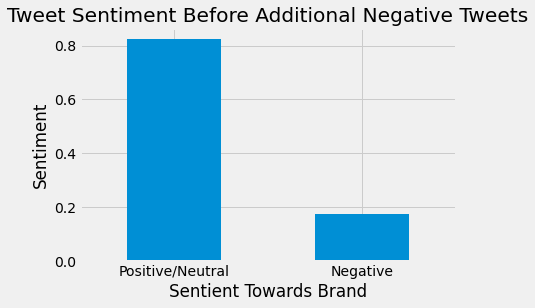

In [67]:
fig, ax = plt.subplots()

labels=['Positive/Neutral','Negative']
plt.style.use('fivethirtyeight')
new_df['Sentiment'].value_counts(normalize=True).plot.bar()
plt.title('Tweet Sentiment Before Additional Negative Tweets')
plt.ylabel('Sentiment')
plt.xlabel('Sentient Towards Brand')
plt.xticks(rotation=0)
ax.set_xticklabels(labels=labels)
plt.show()

In [69]:
len(X)


10155

In [71]:
X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    train_size=0.80,stratify=y)

In [72]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem,
                                          test_size=0.50, random_state=42,stratify=y_rem)


In [73]:
X_val

1402    Startups: Free Premium Service on your  one st job post if you answer our  two  min survey  #sxsw #sxswi #startup #launch                   
4801    Umm. Hello!! What about Android?! RT  Awesome new version of  for iPhone and new web site coming after #sxsw.                               
2356     Congrats on your iPhone app being featured at #SXSW!                                                                                       
1484    like that is bad RT  Sitting at a bar listening to music w  three  people who r all nose down on iPhone. Waitress looks confused. #sxsw     
2427    UBER BRAND SMART: Going To move a ton of iPad two  - #Apple opening a popup shop in Austin for #SxSW   via                                  
                                                           ...                                                                                      
9176      lol iPhone,weak. Get on that Lumia level bruh                                                   

## Conventional Model Selection

As in the modeling notebook the best evaluated model was the Tuned Logistic Regression with additional negative tweets.

In [77]:
LG_GS_Neg = pickle.load(open('/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Saved Models/final_logistic.sav', 'rb'))

In [85]:
np.mean(fn.cross_val_score(LG_GS_Neg.best_estimator_,X_train,y_train,scoring='recall'))

0.8099022928291222

The final model achieved 80% on the training dating on recall during cross-validation.

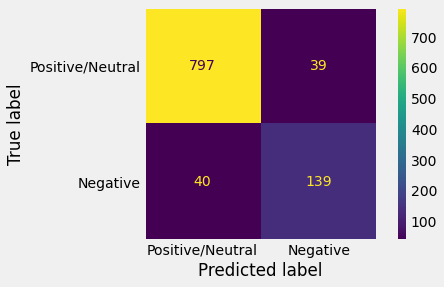

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       836
           1       0.78      0.78      0.78       179

    accuracy                           0.92      1015
   macro avg       0.87      0.86      0.87      1015
weighted avg       0.92      0.92      0.92      1015



In [78]:
fn.reporting(LG_GS_Neg.best_estimator_,X_val,y_val)

It performed slightly worse on the validation data.

## Neural Network Work

I worked with an LSTM neural network. That work can be found in detail in this notebook. I was not able to achieve a score better than that of my best conventional model, so I will leave it as an experiment to explore later.

[Neural Network Notebook](./Neural_Network.ipynb)

## Final Model Selection

In [88]:
cross_val_scores = pd.read_csv('../Data/cross_val_scores')


In [89]:
val_scores = pd.read_csv('../Data/val_scores')

In [93]:
val_scores

Unnamed: 0                                           Name  accuracy  \
0   0           Baseline CB                                    0.926471   
1   1           Logistic_TFIDF                                 0.901070   
2   2           Tune Comp Bayes                                0.840909   
3   3           Logistic_TFIDF                                 0.871658   
4   4           baseline_logistic                              0.827540   
5   5           Logistic_BOW                                   0.874332   
6   6           Tuned Logistic                                 0.827540   
7   10          Random Forrest Added Negs Halving Grid Search  0.928079   
8   7           Grid Search Random Forrest                     0.655080   
9   8           Grid Logistic Addtiional Tweets                0.922167   
10  9           Tuned Comp Bayes Added Neg                     0.915271   

    precision    recall        f1            notes  
0   0.538462   0.125000  0.202899  NaN              
1   0.390244   0.571429  0.463768  N_gram_1,2       
2   0.259542   0.607143  0.363636  NaN              
3   0.318182   0.625000  0.421687  N_gram_1,1       
4   0.248276   0.642857  0.358209  n_grams 1,1,BoW  
5   0.327273   0.642857  0.433735  N_gram_1,2       
6   0.248276   0.642857  0.358209  NaN              
7   0.868056   0.698324  0.773994  NaN              
8   0.141844   0.714286  0.236686  NaN              
9   0.780899   0.776536  0.778711  NaN              
10  0.740933   0.798883  0.768817  NaN

In [90]:
cross_val_scores

Unnamed: 0                                      Name  mean_accuracy  \
0   0           Baseline_svm                              0.928094        
1   1           SVM_BOW                                   0.928094        
2   2           SVM_TFIDF                                 0.928595        
3   3           Baseline Dummy                            0.863880        
4   4           SVM_TFIDF                                 0.928595        
5   5           Baseline Bayes                            0.929264        
6   6           Baseline Random Forrest                   0.931104        
7   7           Logistic_TFIDF                            0.913545        
8   8           Comp Bayes Added Negs                     0.887739        
9   9           Logistic_TFIDF                            0.898662        
10  10          Logistic_BOW                              0.862876        
11  11          Logistic_TFIDF                            0.867057        
12  12          Tuned Logistic Regression                 0.867057        
13  13          Tuned_SVM                                 0.856020        
14  14          Baseline Logistic                         0.829766        
15  15          Grid RF                                   0.722408        
16  16          Baseline Random Forrest_Add_Examples      0.947070        
17  20          Random Forrest Added Negs Halving Search  0.935622        
18  17          Comp Bayes Added Negs                     0.908050        
19  18          Base Log Additional Tweets                0.926268        
20  19          Grid Logistic Additional Tweets           0.929345        

    std_accuracy  mean_precision  std_precision  mean_recall  std_recall  \
0   0.001399      0.822222        0.093953       0.055855     0.023476     
1   0.000916      0.796667        0.112744       0.060300     0.020735     
2   0.000853      0.806883        0.110288       0.066991     0.018701     
3   0.009635      0.081676        0.036418       0.069139     0.026880     
4   0.000853      0.790476        0.122706       0.071436     0.026914     
5   0.002727      0.614499        0.087212       0.144994     0.028733     
6   0.002925      0.665598        0.120304       0.167291     0.037383     
7   0.009138      0.395436        0.086763       0.299001     0.072966     
8   0.004822      0.975987        0.014207       0.371740     0.025968     
9   0.006983      0.357625        0.031299       0.437453     0.025999     
10  0.006099      0.285229        0.022435       0.553308     0.062936     
11  0.004164      0.300116        0.021531       0.584544     0.057838     
12  0.004164      0.300116        0.021531       0.584544     0.057838     
13  0.003234      0.284699        0.009235       0.611411     0.053870     
14  0.008388      0.245816        0.022980       0.615780     0.062758     
15  0.026052      0.156377        0.006583       0.642747     0.046535     
16  0.005791      0.962621        0.009011       0.722548     0.025791     
17  0.004925      0.912504        0.015382       0.726028     0.021412     
18  0.008261      0.714311        0.023215       0.797315     0.026714     
19  0.003799      0.787183        0.014182       0.797329     0.020037     
20  0.004527      0.793723        0.017728       0.809902     0.019774     

     mean_f1    std_f1                            notes  
0   0.102999  0.042225  NaN                              
1   0.110521  0.036022  ngram 1,2                        
2   0.122359  0.031673  ngram_1,2                        
3   0.066957  0.012847  NaN                              
4   0.128624  0.043989  ngram_1,1                        
5   0.234251  0.043402  NaN                              
6   0.274529  0.049378  NaN                              
7   0.339969  0.078817  N_grams2,2                       
8   0.537941  0.028075  NaN                              
9   0.393250  0.028001  N_grams1,2                       
10  0.376122  0.032752  N_Grams_1,2       

### Final Testing Data

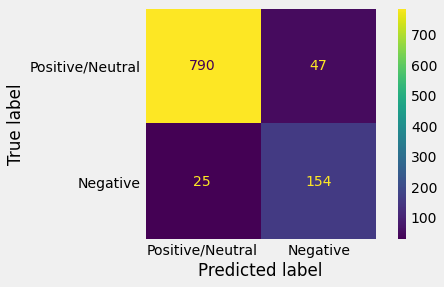

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       837
           1       0.77      0.86      0.81       179

    accuracy                           0.93      1016
   macro avg       0.87      0.90      0.88      1016
weighted avg       0.93      0.93      0.93      1016



In [91]:
fn.reporting(LG_GS_Neg.best_estimator_,X_test,y_test)


The final model I am choosing is a tuned logistic regression model using a TFIDF vectorization and unigrams. Intuitively I want to use bigrams, as I do think the EDA revealed some interesting phrases, but there were better scores without them. The neural networks were almost as a good as the logistic regression model, but, I the cross-validation scores were consistent with the scores on the validation set. I trust this model the most because I have scored this model thoroughly. There were decision points that gave me pause, but there is enough in the dataset that pushed me towrads this model.

### Model Interpretation

In [95]:
coeffecients = LG_GS_Neg.best_estimator_.steps[1][1].coef_.flatten()
feature_names = LG_GS_Neg.best_estimator_.steps[0][1].get_feature_names_out()

In [99]:
from re import sub

In [96]:
def replace_content(dict_replace, target):
    """Based on dict, replaces key with the value on the target."""

    for check, replacer in list(dict_replace.items()):
        target = sub(check, replacer, target)
        # target = target.replace(check, replacer)

    return target


# check : replacer
dict_replace = {
    'fuck': 'f*ck',
    'cunt,': 'c*nt',
    'fucking': 'f*cking',
    'shit':'sh!t',
    'asshole':'a$$h*le',
}

In [97]:
zipped = zip(feature_names,coeffecients)
coef_df = pd.DataFrame(zipped, columns=['feature', 'value'])
coef_df["abs_value"] = coef_df["value"].apply(lambda x: abs(x))
coef_df = coef_df.sort_values("abs_value", ascending=False)
coef_df["colors"] = coef_df["value"].apply(lambda x: "red" if x > 0 else "blue")

In [100]:
coef_df['feature'] = coef_df['feature'].map(lambda x: (replace_content(dict_replace,x)))

In [102]:
top_coef = coef_df.head(15)

Text(0.5, 0, 'Features')

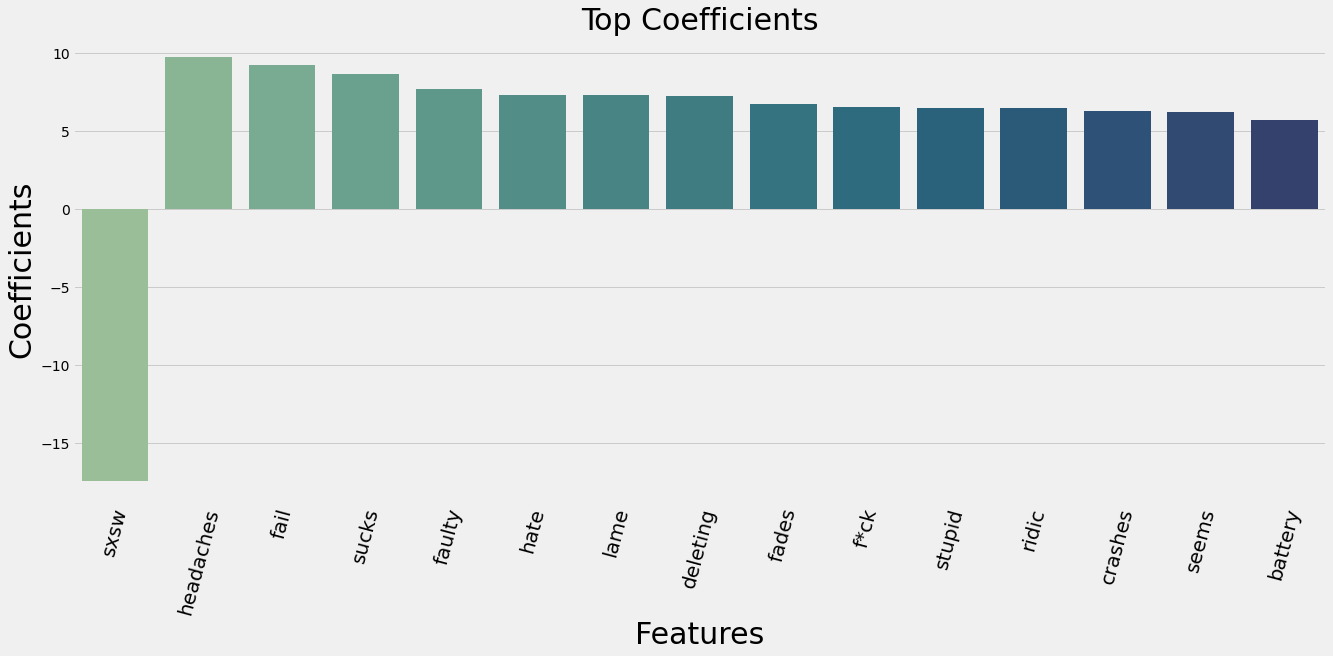

In [103]:
fig, ax = plt.subplots(figsize=(20,8))
plt.xticks(rotation=75)
plt.xticks(size=20)
ax.set_title('Top Coefficients',size=30)
sns.barplot(data=top_coef,x='feature',y='value',palette='crest')
ax.set_ylabel('Coefficients',size=30)
ax.set_xlabel('Features',size=30)

In [104]:
top_15= coef_df.sort_values(by='abs_value',ascending=False).head(15)
top_poz_coef_10 = coef_df[coef_df['value']<0].head(10)
top_neg_coef_10 = coef_df[coef_df['value']>0].head(10)

In [105]:
top_neg_coef_10

feature     value  abs_value colors
3673  headaches  9.780112  9.780112   red  
2829  fail       9.239606  9.239606   red  
7764  sucks      8.696747  8.696747   red  
2886  faulty     7.706158  7.706158   red  
3642  hate       7.341673  7.341673   red  
4501  lame       7.318396  7.318396   red  
2030  deleting   7.263459  7.263459   red  
2826  fades      6.754077  6.754077   red  
3204  f*ck       6.521560  6.521560   red  
7739  stupid     6.455944  6.455944   red

Text(0.5, 0, 'Features')

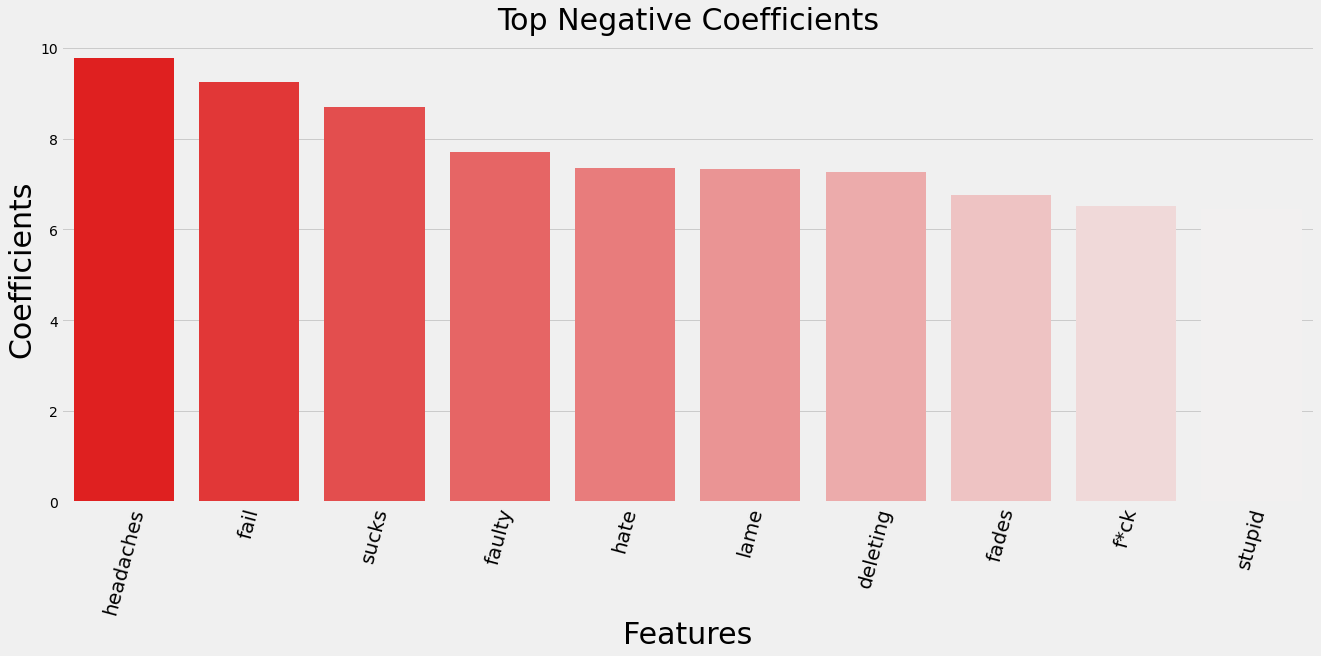

In [106]:
fig, ax = plt.subplots(figsize=(20,8))
plt.xticks(rotation=75)
plt.xticks(size=20)
ax.set_title('Top Negative Coefficients',size=30)
sns.barplot(data=top_neg_coef_10,x='feature',y='value',palette='light:r_r')
ax.set_ylabel('Coefficients',size=30)
ax.set_xlabel('Features',size=30)

Text(0.5, 0, 'Features')

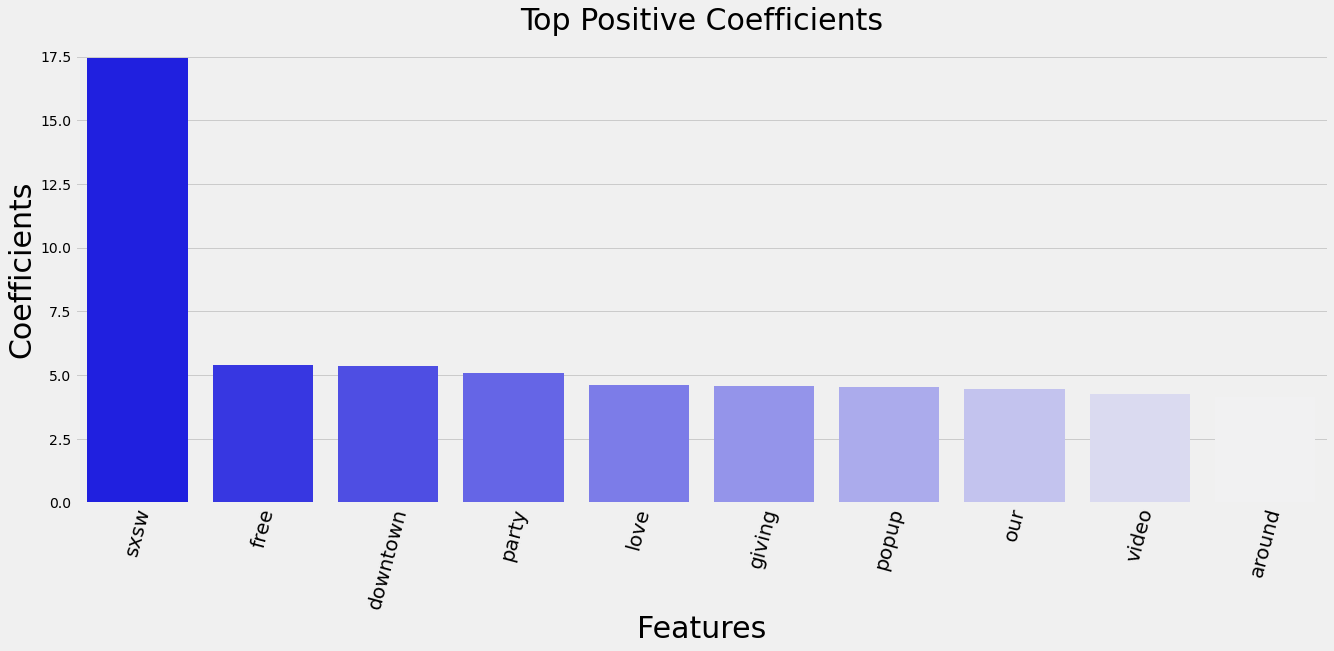

In [107]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=top_poz_coef_10,x='feature',y='abs_value',palette="light:b_r")
ax.set_title('Top Positive Coefficients',size=30)
ax.tick_params(axis='x', labelrotation = 75,labelsize=20)
ax.set_ylabel('Coefficients',size=30)
ax.set_xlabel('Features',size=30)




In [108]:
np.sum(coef_df['value']>0)

2556

In [109]:
np.sum(coef_df['value']<0)

6676

There are far more positive coefficients than negative coefficients, the negative coefficients appear to have a larger affect on the prediction.

#### ROC Curve

In [110]:
y_pred_prob = LG_GS_Neg.best_estimator_.predict_proba(X_test)
lr_probs = y_pred_prob[:, 1]

In [111]:
lr_probs

array([0.0212042 , 0.00172895, 0.51685219, ..., 0.05344573, 0.00902241,
       0.04519285])

In [112]:
ns_probs = [0 for _ in range(len(y_test))]

In [115]:
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [116]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.958


In [117]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

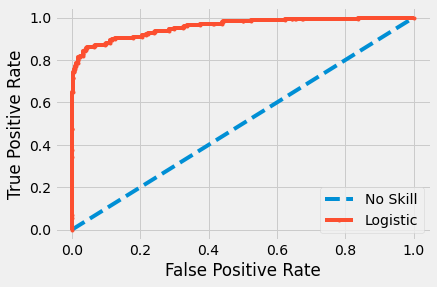

In [120]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#### Word Clouds Based on Brands

In [121]:
coef_df

feature      value  abs_value colors
7872  sxsw         -17.437448  17.437448  blue 
3673  headaches     9.780112   9.780112   red  
2829  fail          9.239606   9.239606   red  
7764  sucks         8.696747   8.696747   red  
2886  faulty        7.706158   7.706158   red  
...      ...             ...        ...   ...  
1311  chavez       -0.000325   0.000325   blue 
7870  sxsma        -0.000299   0.000299   blue 
8225  tipb         -0.000290   0.000290   blue 
8011  team_android -0.000118   0.000118   blue 
6707  retailers    -0.000091   0.000091   blue 

[9232 rows x 4 columns]

In [122]:
new_df[new_df['Product']=='Apple']

tweet_text  \
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                           
39     @mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2   
46     HOORAY RT @mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link}                                                           
48     wooooo!!! @mention Apple store downtown Austin open til Midnight. #sxsw۝                                                                           
61     #OMFG! RT @mention Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla: {link} #sxsw #iPad2                           
...                                                                                                                         ...                           
10150  RT @Ecofantasy: Thinking of upgrading to #Yosemite? Think twice  http://t.co/dU0Mpaw5Ri It's not for everyone. RT #ASMSG @Apple                    
10151  why isnt group facetime a thing @apple wtf                                                                                                         
10152  Being held hostage at @apple - They are replacing the whole phone. Last backup at 630 a.m. this morning so anything since was byebyebye.           
10153  hey @apple is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                       
10154  My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?                  

      Product  Sentiment  \
8      Apple   0           
39     Apple   0           
46     Apple   0           
48     Apple   0           
61     Apple   0           
...      ...  ..           
10150  Apple   1           
10151  Apple   1           
10152  Apple   1           
10153  Apple   1           
10154  Apple   1           

                                                                                                                                                processed_text  
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                                 
39       - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up "flash store" downtown to sell iPad two                        
46     HOORAY RT  Apple Is Opening A Pop-Up Store In Austin For #SXSW |                                                                                         
48     wooooo!!!  Apple store downtown Austin open til Midnight. #sxsw                                                                                          
61     OMFG! RT  Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla:  #sxsw #iPad two                                             
...                                                                                                              ...                                            
10150  RT : Thinking of upgrading to #Yosemite? Think twice    It is not for everyone. RT #ASMSG                                                                
10151  why is not group facetime a thing  wtf                                                                                                                   
10152  Being held hostage at  - They are replacing the whole phone. Last backup at  six hundred and thirty  a.m. this morning so anything since was byebyebye.  
10153  hey  is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                                   
10154  My iPhone  five 's photos are no longer downloading automatically to my laptop when I sync it.  support is unhelpful. Any ideas?                         

[1878 rows

In [123]:
new_df[new_df['Product']=='Apple']

tweet_text  \
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                           
39     @mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2   
46     HOORAY RT @mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link}                                                           
48     wooooo!!! @mention Apple store downtown Austin open til Midnight. #sxsw۝                                                                           
61     #OMFG! RT @mention Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla: {link} #sxsw #iPad2                           
...                                                                                                                         ...                           
10150  RT @Ecofantasy: Thinking of upgrading to #Yosemite? Think twice  http://t.co/dU0Mpaw5Ri It's not for everyone. RT #ASMSG @Apple                    
10151  why isnt group facetime a thing @apple wtf                                                                                                         
10152  Being held hostage at @apple - They are replacing the whole phone. Last backup at 630 a.m. this morning so anything since was byebyebye.           
10153  hey @apple is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                       
10154  My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?                  

      Product  Sentiment  \
8      Apple   0           
39     Apple   0           
46     Apple   0           
48     Apple   0           
61     Apple   0           
...      ...  ..           
10150  Apple   1           
10151  Apple   1           
10152  Apple   1           
10153  Apple   1           
10154  Apple   1           

                                                                                                                                                processed_text  
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                                 
39       - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up "flash store" downtown to sell iPad two                        
46     HOORAY RT  Apple Is Opening A Pop-Up Store In Austin For #SXSW |                                                                                         
48     wooooo!!!  Apple store downtown Austin open til Midnight. #sxsw                                                                                          
61     OMFG! RT  Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla:  #sxsw #iPad two                                             
...                                                                                                              ...                                            
10150  RT : Thinking of upgrading to #Yosemite? Think twice    It is not for everyone. RT #ASMSG                                                                
10151  why is not group facetime a thing  wtf                                                                                                                   
10152  Being held hostage at  - They are replacing the whole phone. Last backup at  six hundred and thirty  a.m. this morning so anything since was byebyebye.  
10153  hey  is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                                   
10154  My iPhone  five 's photos are no longer downloading automatically to my laptop when I sync it.  support is unhelpful. Any ideas?                         

[1878 rows

In [127]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),use_idf=False,max_df=.9,)
vectorizer.fit_transform(new_df['processed_text'])


<10155x10184 sparse matrix of type '<class 'numpy.float64'>'
	with 156305 stored elements in Compressed Sparse Row format>

In [128]:
vectorizer.transform(new_df[new_df['Product']=='Apple']['processed_text'])

<1878x10184 sparse matrix of type '<class 'numpy.float64'>'
	with 27152 stored elements in Compressed Sparse Row format>

In [129]:
bag_of_words = vectorizer.transform(new_df[new_df['Product']=='Google']['processed_text'])


#### Function to Get Frequencies to Plot

In [130]:
def get_brand_frequencies(data,brand,model,sentiment):
    #set corpus as overall dataset
    corpus = data['processed_text']
    #fit vectorizer on corpus
    vectorizer = TfidfVectorizer(ngram_range=(1,1),use_idf=False,max_df=.9)
    vectorizer.fit_transform(corpus)
    #Transform on specific brand
    bag_of_words = vectorizer.transform(data[data['Product']==brand]['processed_text'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    #Create word frequencies 
    brand_frame = pd.DataFrame(words_freq,columns=['Word','Frequency'])
    brand_frame['Probability']=brand_frame['Word'].map(lambda x: model.best_estimator_.predict_proba([x]))
    brand_frame['Negative']=brand_frame['Probability'].map(lambda x: x[0][1])
    brand_frame['Positive']=brand_frame['Probability'].map(lambda x: x[0][0])
    sorted_frame = brand_frame.sort_values(by=sentiment,ascending=False)[0:200]
    sorted_frame['Word'] = sorted_frame['Word'].map(lambda x: (replace_content(dict_replace,x)))
    sorted_frame[['Word','Frequency']][0:200]
    dictionary = dict(zip(sorted_frame.Word, sorted_frame.Frequency))
    return dictionary

#### Word Clouds for Products

In [131]:
LG_GS_Neg.best_estimator_.classes_

array([0, 1], dtype=uint8)

In [132]:
Apple_Neg_freq = get_brand_frequencies(new_df,'Apple',LG_GS_Neg,sentiment='Negative')
Apple_Poz_freq = get_brand_frequencies(new_df,'Apple',LG_GS_Neg,sentiment='Positive')

In [133]:
iPad_Neg_freq = get_brand_frequencies(new_df,'iPad',LG_GS_Neg,sentiment='Negative')
iPad_Poz_freq = get_brand_frequencies(new_df,'iPad',LG_GS_Neg,sentiment='Positive')

In [134]:
Google_Neg_freq = get_brand_frequencies(new_df,'Google',LG_GS_Neg,sentiment='Negative')
Google_Poz_freq = get_brand_frequencies(new_df,'Google',LG_GS_Neg,sentiment='Positive')

In [135]:
iPhone_Neg_freq = get_brand_frequencies(new_df,'iPhone',LG_GS_Neg,sentiment='Negative')
iPhone_Poz_freq = get_brand_frequencies(new_df,'iPhone',LG_GS_Neg,sentiment='Positive')

In [136]:
new_df['Product'].value_counts(normalize=True)

Apple                              0.417241
iPad                               0.209287
iPad or iPhone App                 0.104421
Google                             0.095312
iPhone                             0.065763
Other Google product or service    0.064874
Android App                        0.017996
Android                            0.017329
Other Apple product or service     0.007776
Name: Product, dtype: float64

In [137]:
apple_poz_freq = get_brand_frequencies(new_df,'Apple',LG_GS_Neg,sentiment='Positive')

In [138]:
Apple_Poz_freq = {key: Apple_Poz_freq[key] for key in Apple_Poz_freq if key not in sw}
Apple_Neg_freq = {key: Apple_Neg_freq[key] for key in Apple_Neg_freq if key not in sw}
Google_Poz_freq = {key: Google_Poz_freq[key] for key in Google_Poz_freq if key not in sw}
Google_Neg_freq = {key: Google_Neg_freq[key] for key in Google_Neg_freq if key not in sw}
iPad_Neg_freq = {key: iPad_Neg_freq[key] for key in iPad_Neg_freq if key not in sw}
iPad_Poz_freq = {key: iPad_Poz_freq[key] for key in iPad_Poz_freq if key not in sw}
iPhone_Poz_freq = {key: iPhone_Poz_freq[key] for key in iPhone_Poz_freq if key not in sw}
iPhone_Neg_freq = {key: iPhone_Neg_freq[key] for key in iPhone_Neg_freq if key not in sw}

In [139]:
def display_cloud(dic,title,color):
    wc = WordCloud(stopwords=sw,width=1000, height=760,normalize_plurals=False,colormap=color).generate_from_frequencies(dic)
    plt.figure( figsize=(20,10))
    plt.imshow(wc)
    plt.title(title)
    plt.axis("off")
    plt.show()

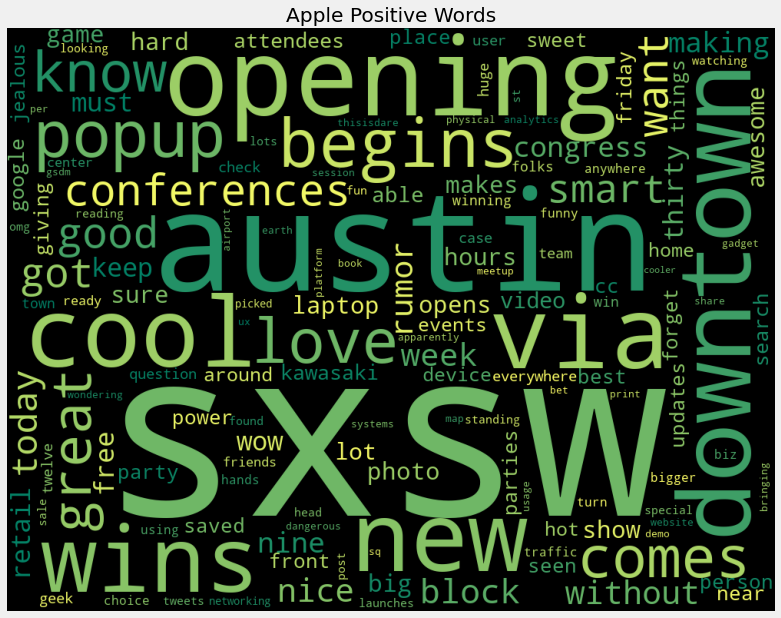

In [141]:
display_cloud(Apple_Poz_freq,'Apple Positive Words',color='summer')

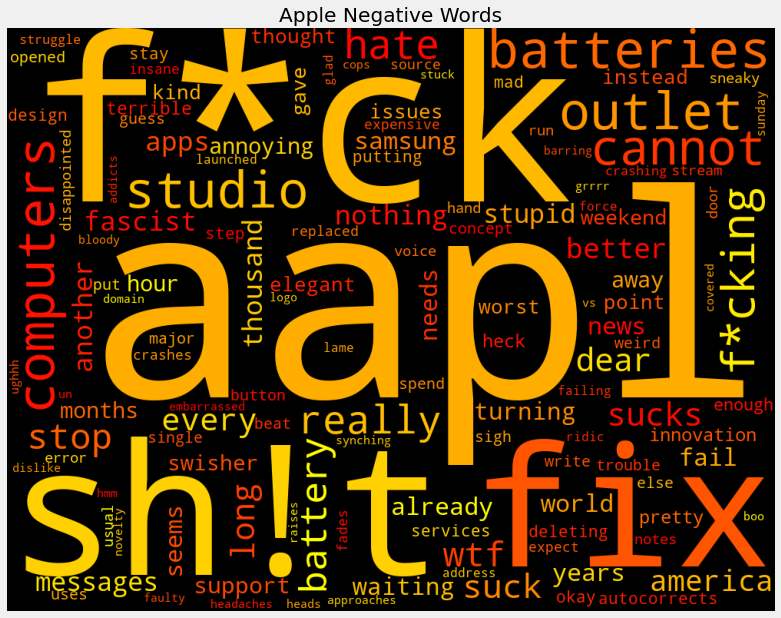

In [142]:
display_cloud(Apple_Neg_freq,'Apple Negative Words',color='autumn')

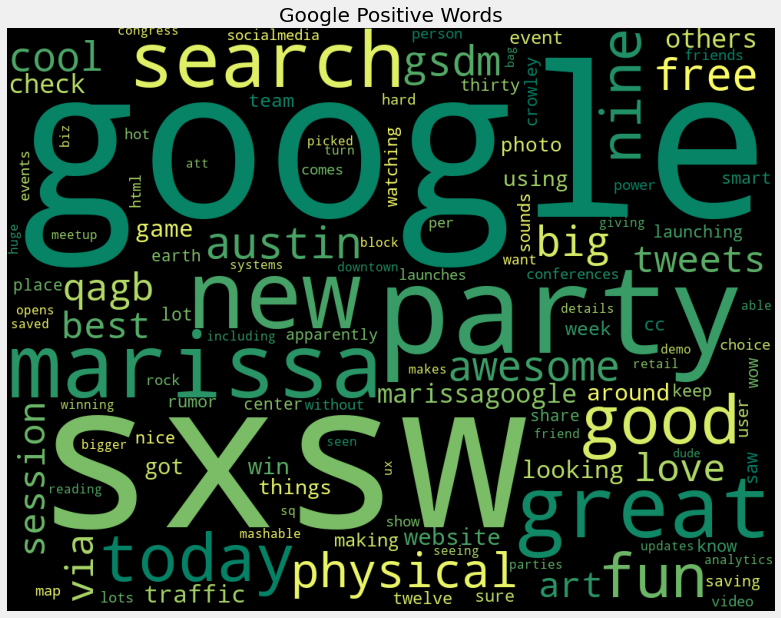

In [143]:
display_cloud(Google_Poz_freq,'Google Positive Words',color='summer')

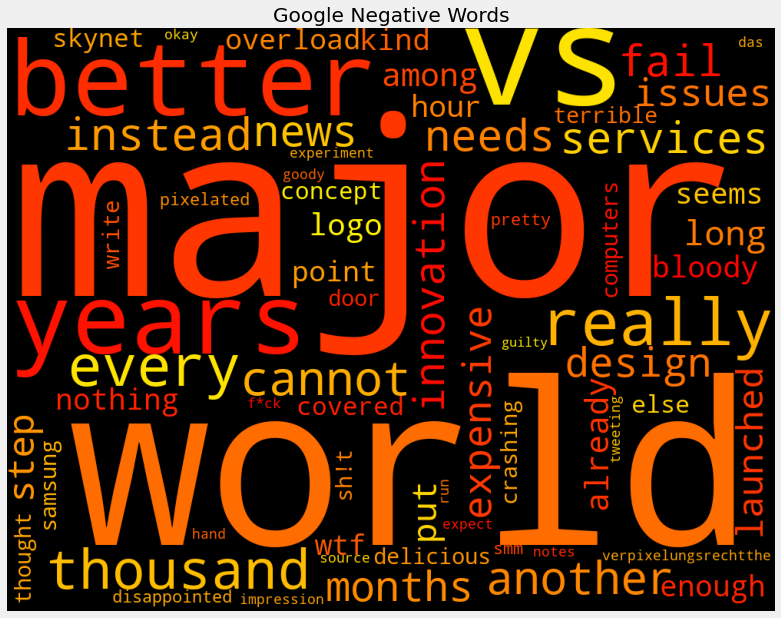

In [144]:
display_cloud(Google_Neg_freq,'Google Negative Words',color='autumn')

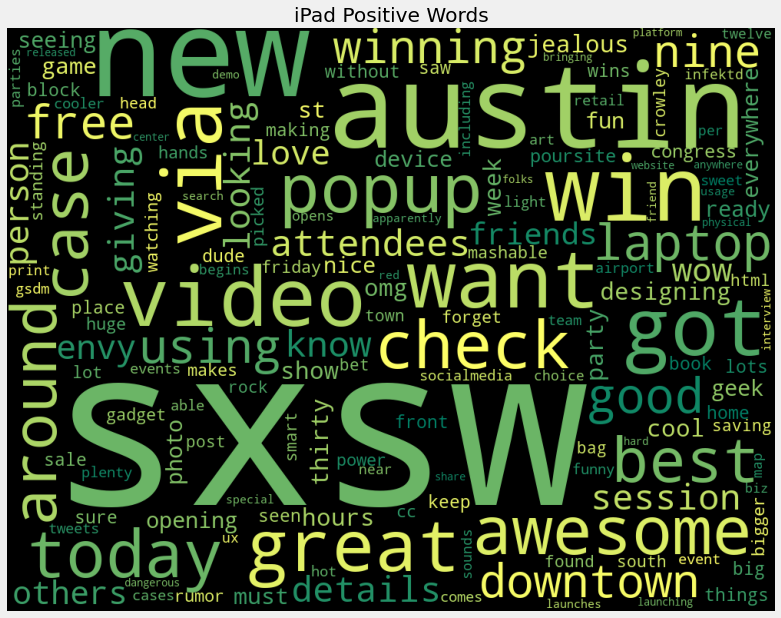

In [145]:
display_cloud(iPad_Poz_freq,'iPad Positive Words',color='summer')

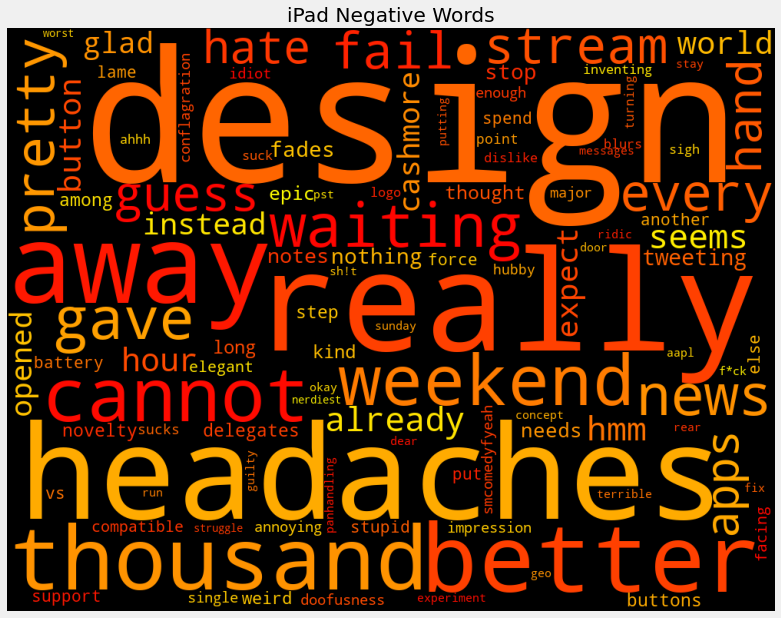

In [146]:
display_cloud(iPad_Neg_freq,'iPad Negative Words',color='autumn')

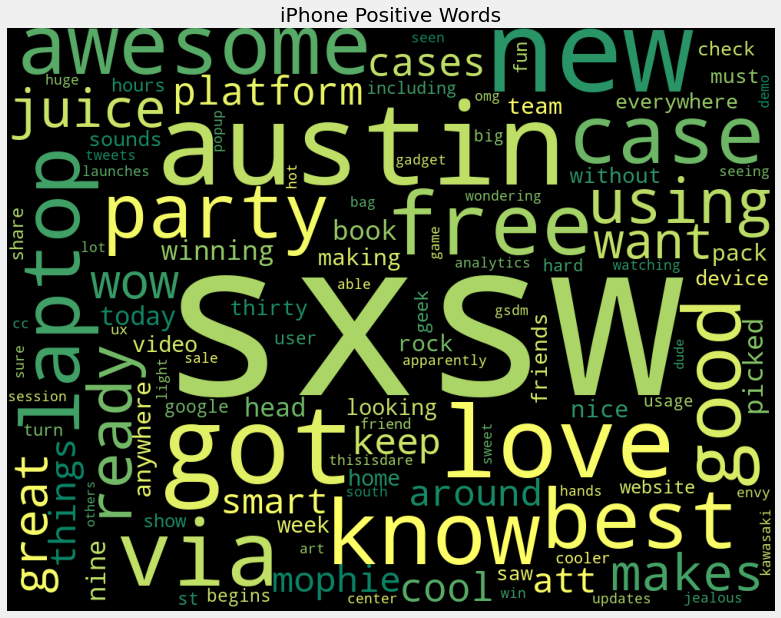

In [147]:
display_cloud(iPhone_Poz_freq,'iPhone Positive Words',color='summer')

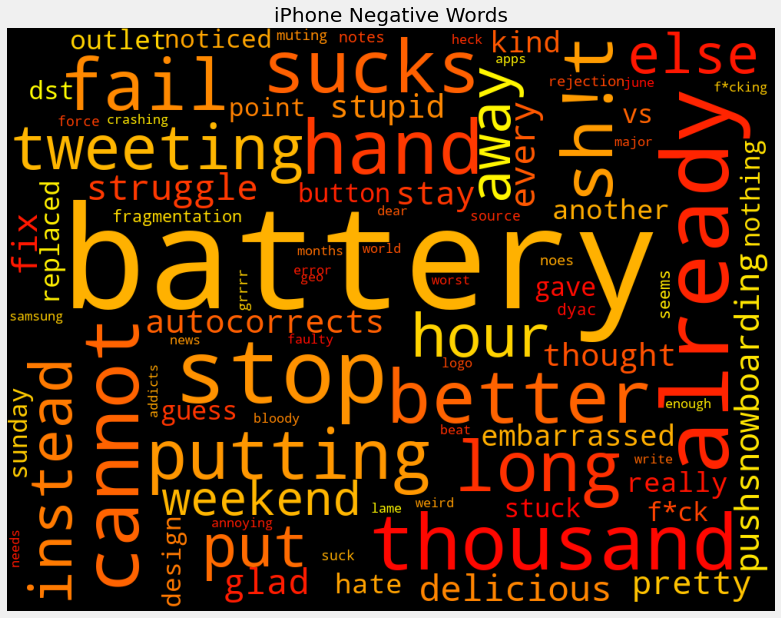

In [148]:
display_cloud(iPhone_Neg_freq,'iPhone Negative Words',color='autumn')

#### Recomendations

The modeling process revealed how much consumers valued free stuff and parties. Considering this was a large-scale event, this means give-aways and popups. People responded poorly to battery-life issues and had a negative opinion on of Apple on the company on the whole in terms of "fascist" appearing in the wordclouds. 

## Conclusions and Further Work

For further modeling I am interested in how to use emojis and GIFs as they represent a modern form of communication in Tweets. Sarcasm is also hard for this simple form of model to detect. NLP itself is challenging, as is dealing with an imbalanced dataset such as this one. 

More tweets would also be helpful as would be strategies for various NLP challenges - learning how to use processing as itself a hyperparameter.